# Calcul Matriciel

# PageRank
***
_merci à Eddie Aamari pour ses remarques et corrections_

***
Ce TP s'intéresse au _ranking_ au sein d'un graphe orienté. Il s'agit d'un domaine qui s'intéresse aux façon de mesurer l'importance / la pertinence des noeuds d'un graphe. 

Dans le contexte de la recherche sur le Web, la pertinence dépend généralement du contenu d'une page Web : si une page Web contient les termes de recherche, nous supposons qu'elle est pertinente par rapport aux termes de recherche.

La qualité d'une page Web dépend aussi des liens entre les pages : s'il existe de nombreux liens vers une page particulière, il est vraisemblable qu'elle soit de haute qualité, surtout si ces liens proviennent de pages qui sont elles-mêmes de haute qualité.

L'un des premiers algorithmes à quantifier la qualité est le **PageRank**, qui était au cœur du moteur de recherche original de Google.
Comparé aux [moteurs de recherche antérieurs](https://www.makeuseof.com/tag/7-search-engines-that-rocked-before-google-even-existed/), cet algorithme a permis un bond significatif dans la qualité des résultats obtenus.

PageRank est décrit dans ["The PageRank citation ranking: Bringing order to the Web"](https://web.archive.org/web/20110818093436/http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) par Page, Brin, Motwani et Winograd.

C'est un algorithme étonnamment simple. Il peut être calculé efficacement, et il est très efficace pour identifier les pages de bonne qualité.

In [2]:
import networkx as nx
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [20, 15]

Comme exemple, on pourra utiliser un graphe `G` généré avec `random_k_out_graph` :

* Chaque nœud a le même nombre de liens sortants `k`,

* Le nombre de liens entrants varie modérément (contrôlé par le paramètre 'alpha').

* Les auto-boucles et les liens multiples sont autorisés.

In [3]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

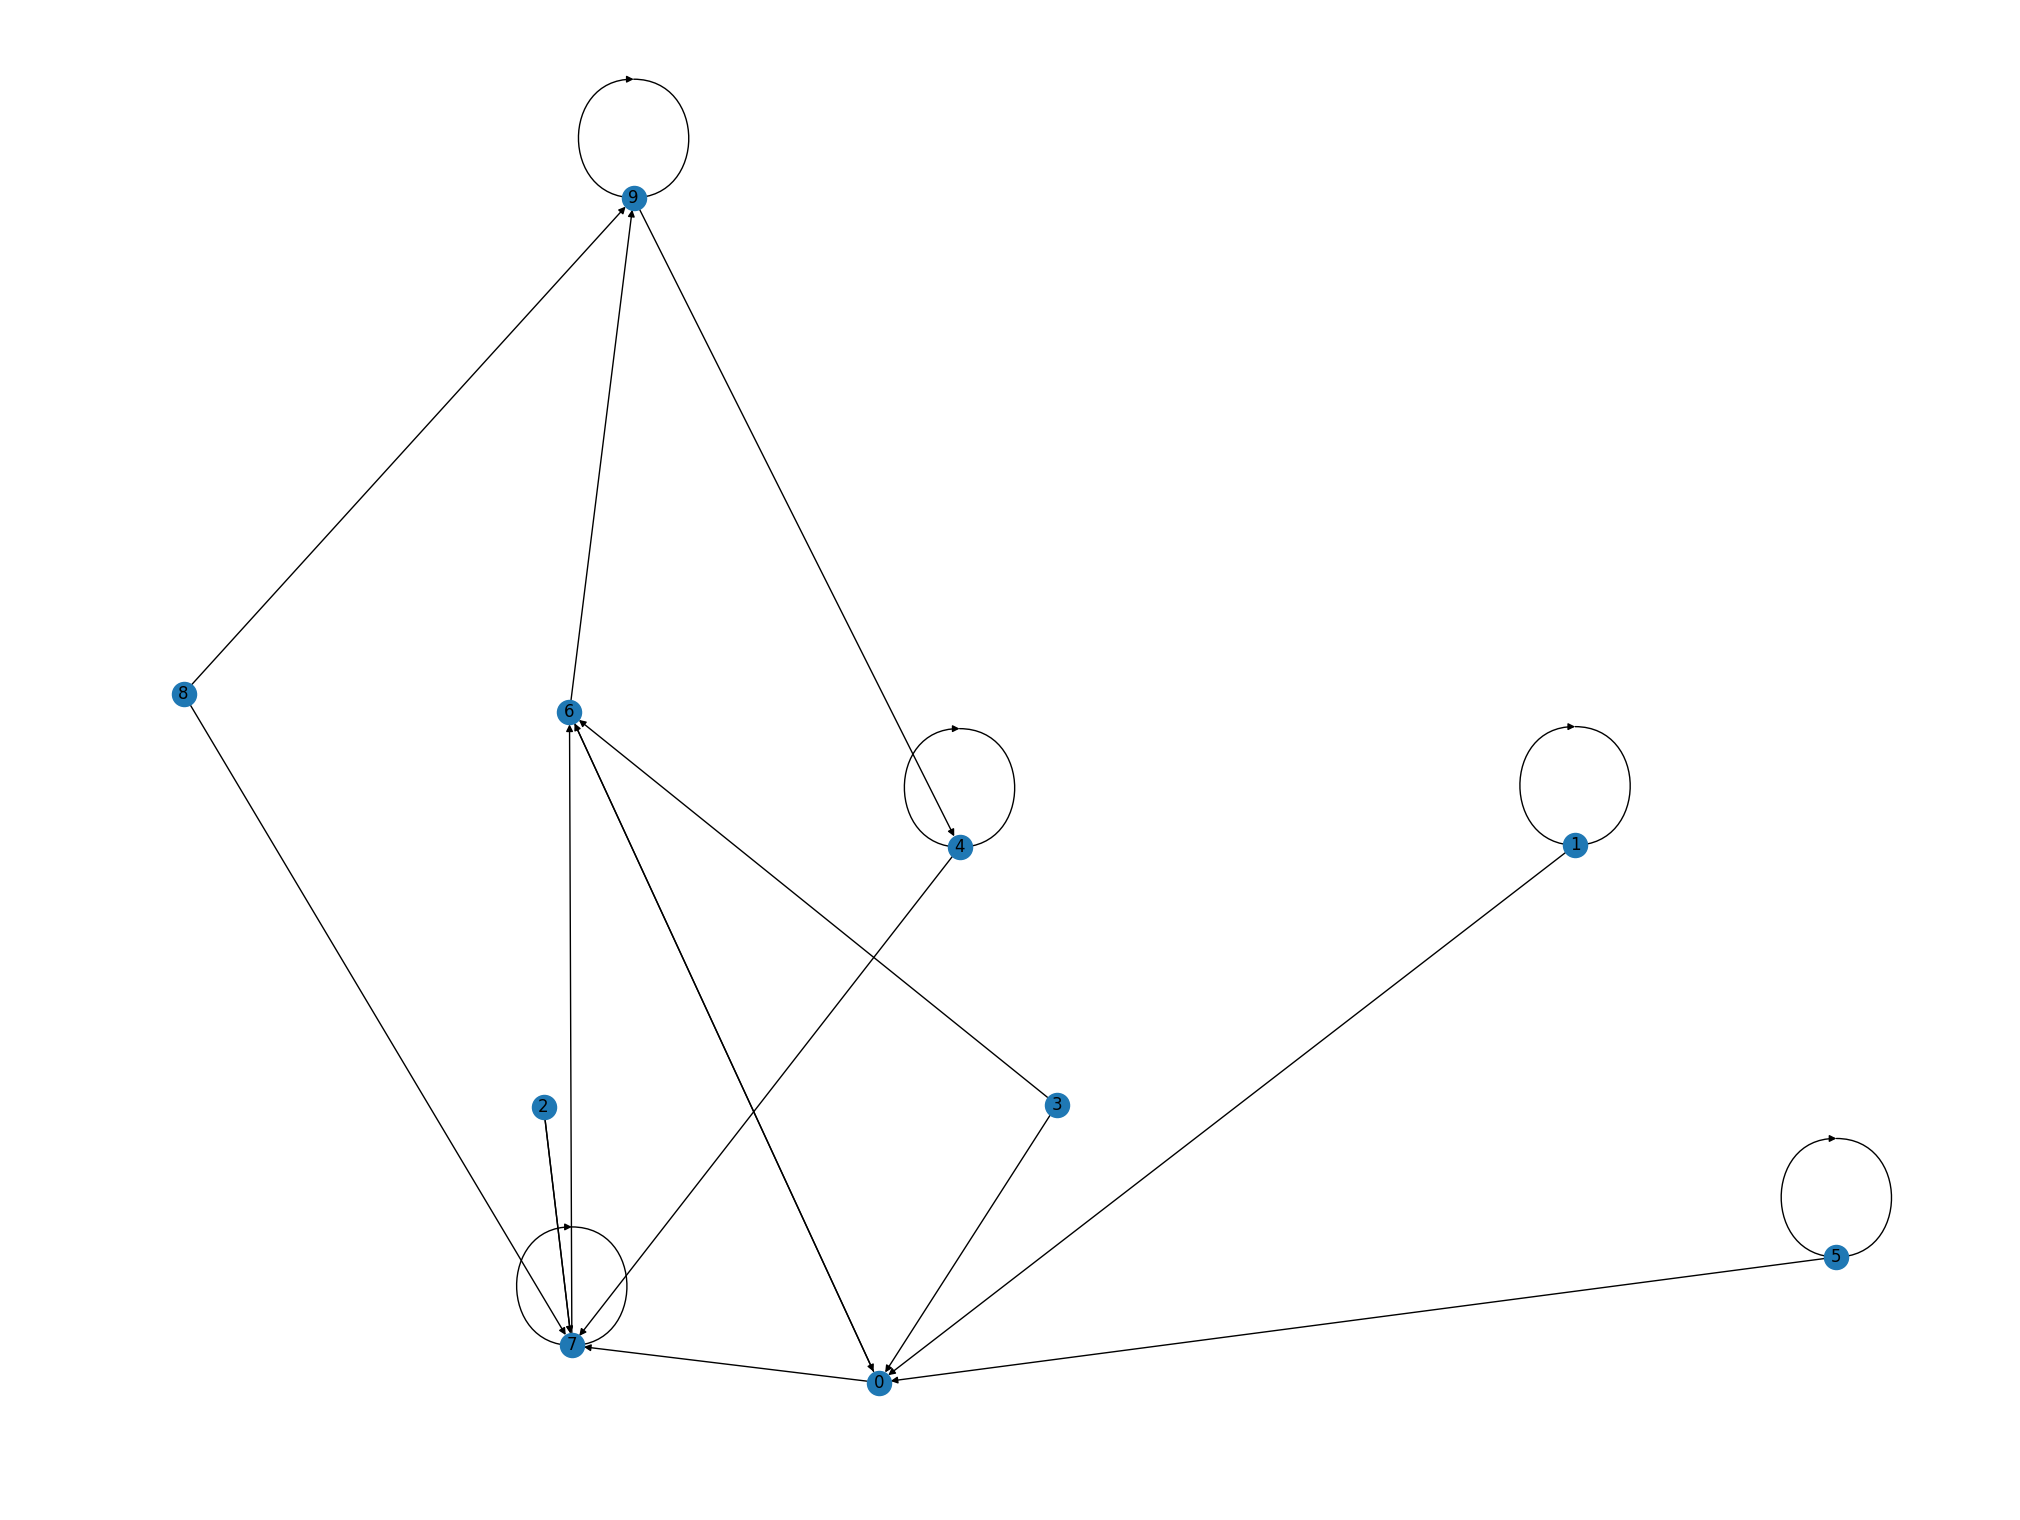

In [4]:
nx.draw(G,with_labels=True)

`NetworkX` fournit une implémentation `nx.pagerank` de PageRank que nous pouvons utiliser pour calculer une métrique "d'importance" pour chaque page (noeud). Essayer sur différents graphes `G`. Vous devriez constater que les nœuds avec plus de liens entrants obtiennent des scores plus élevés.

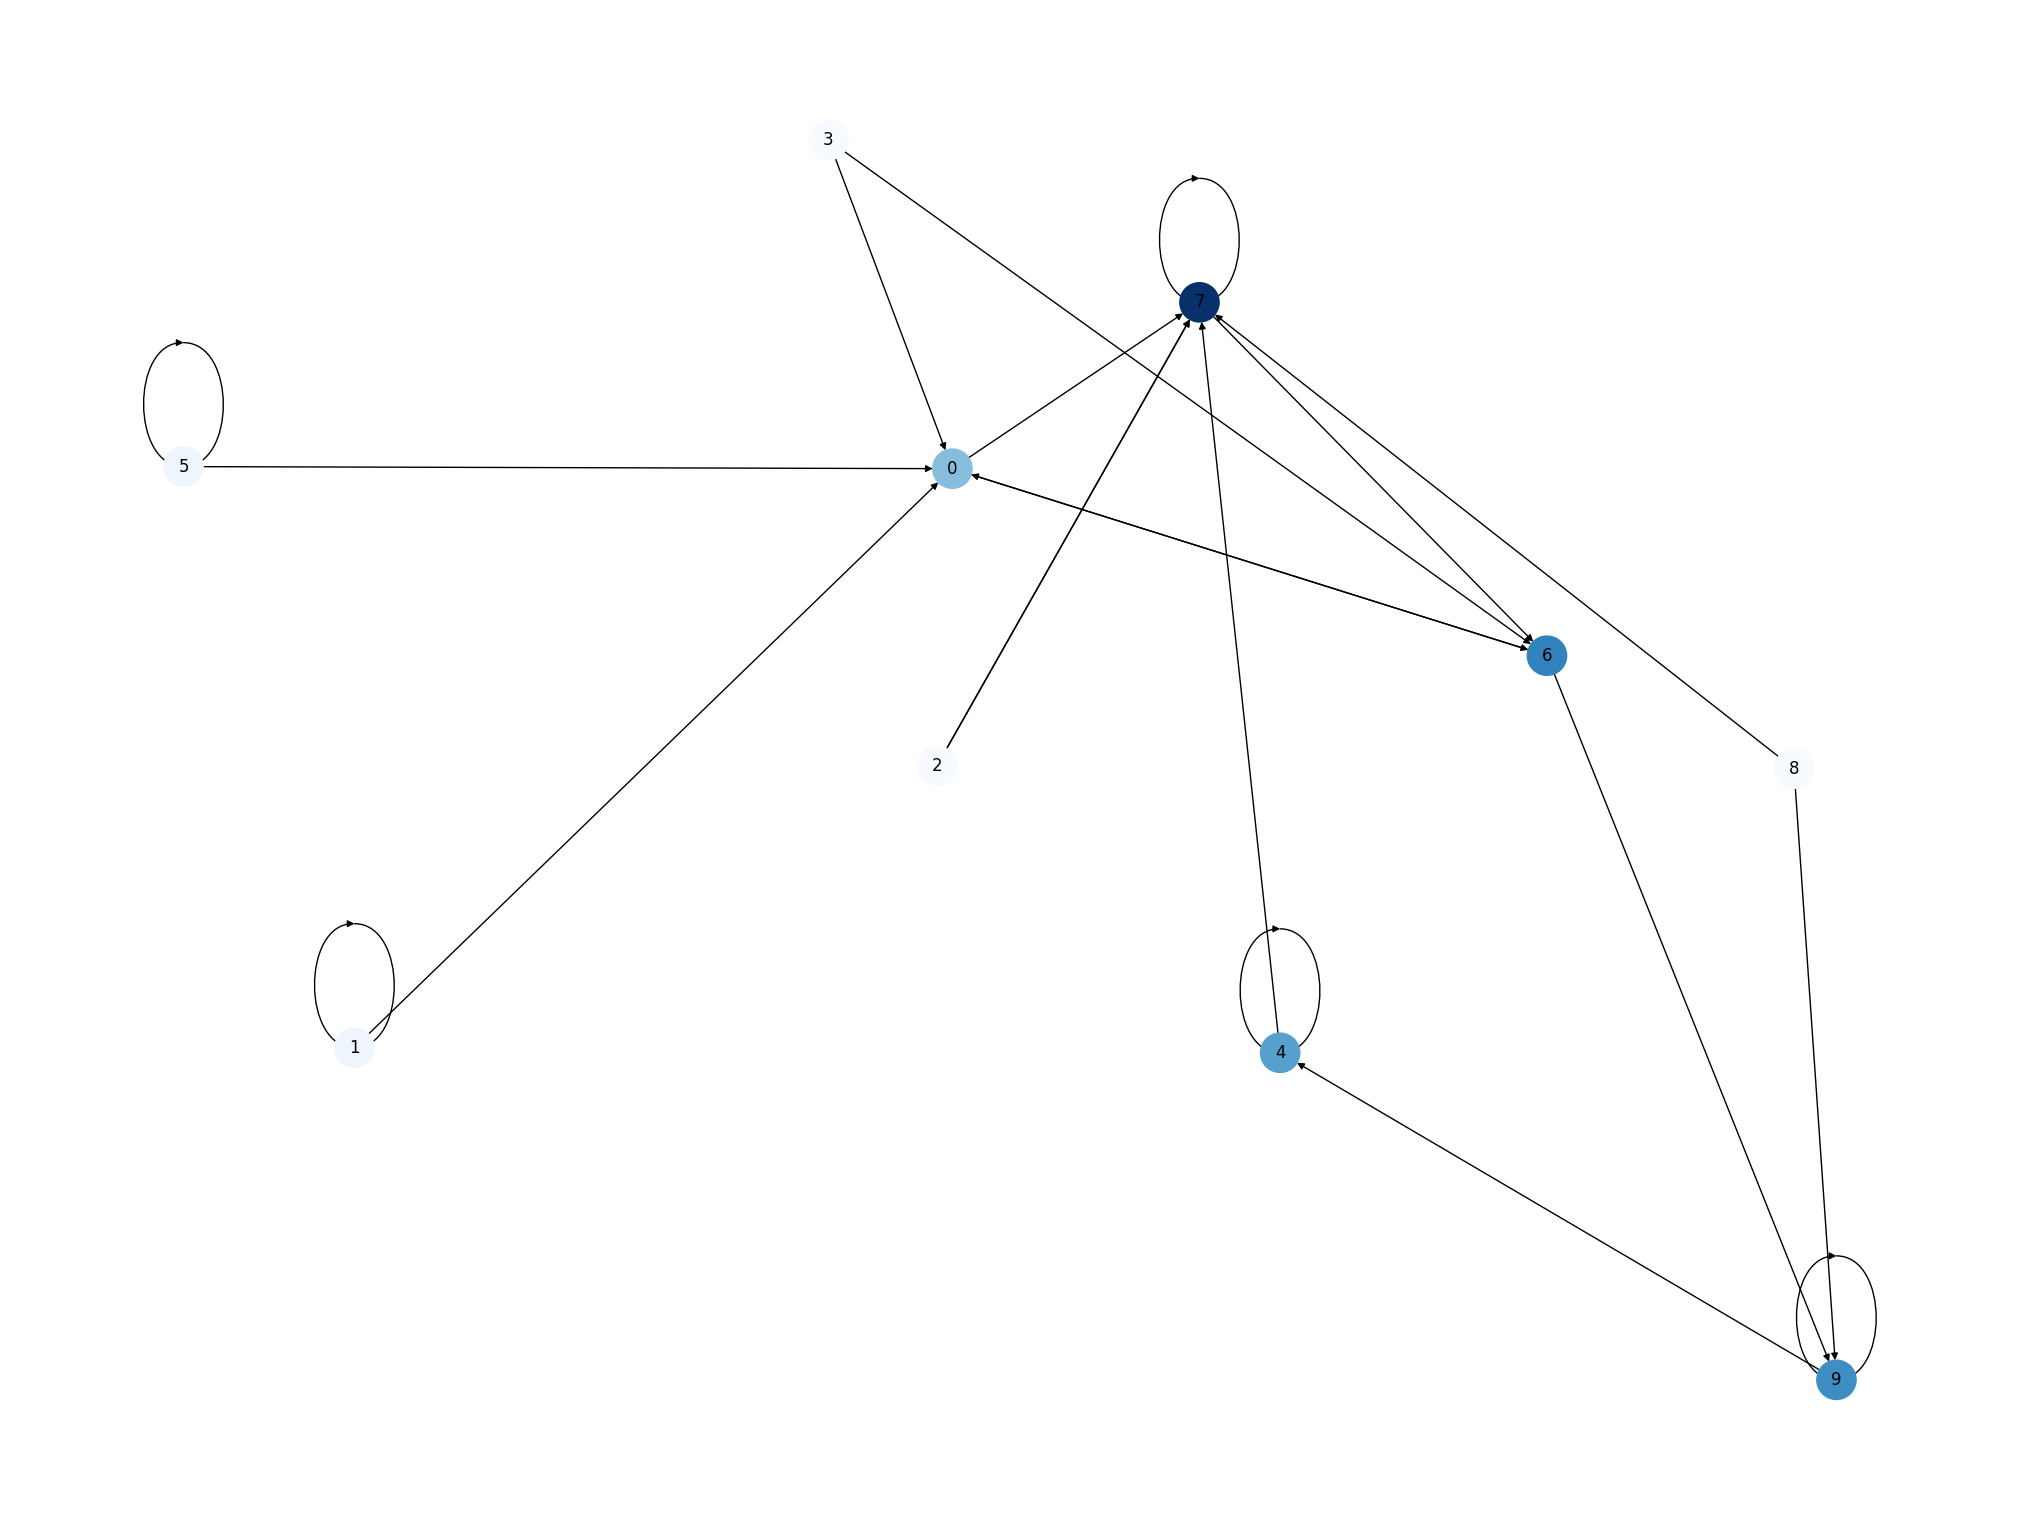

In [5]:
rangs_pr = nx.pagerank(G)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

Visualiser l'importance donnée aux noeuds des trois graphes suivant par PageRank. Interpréter les résultats.

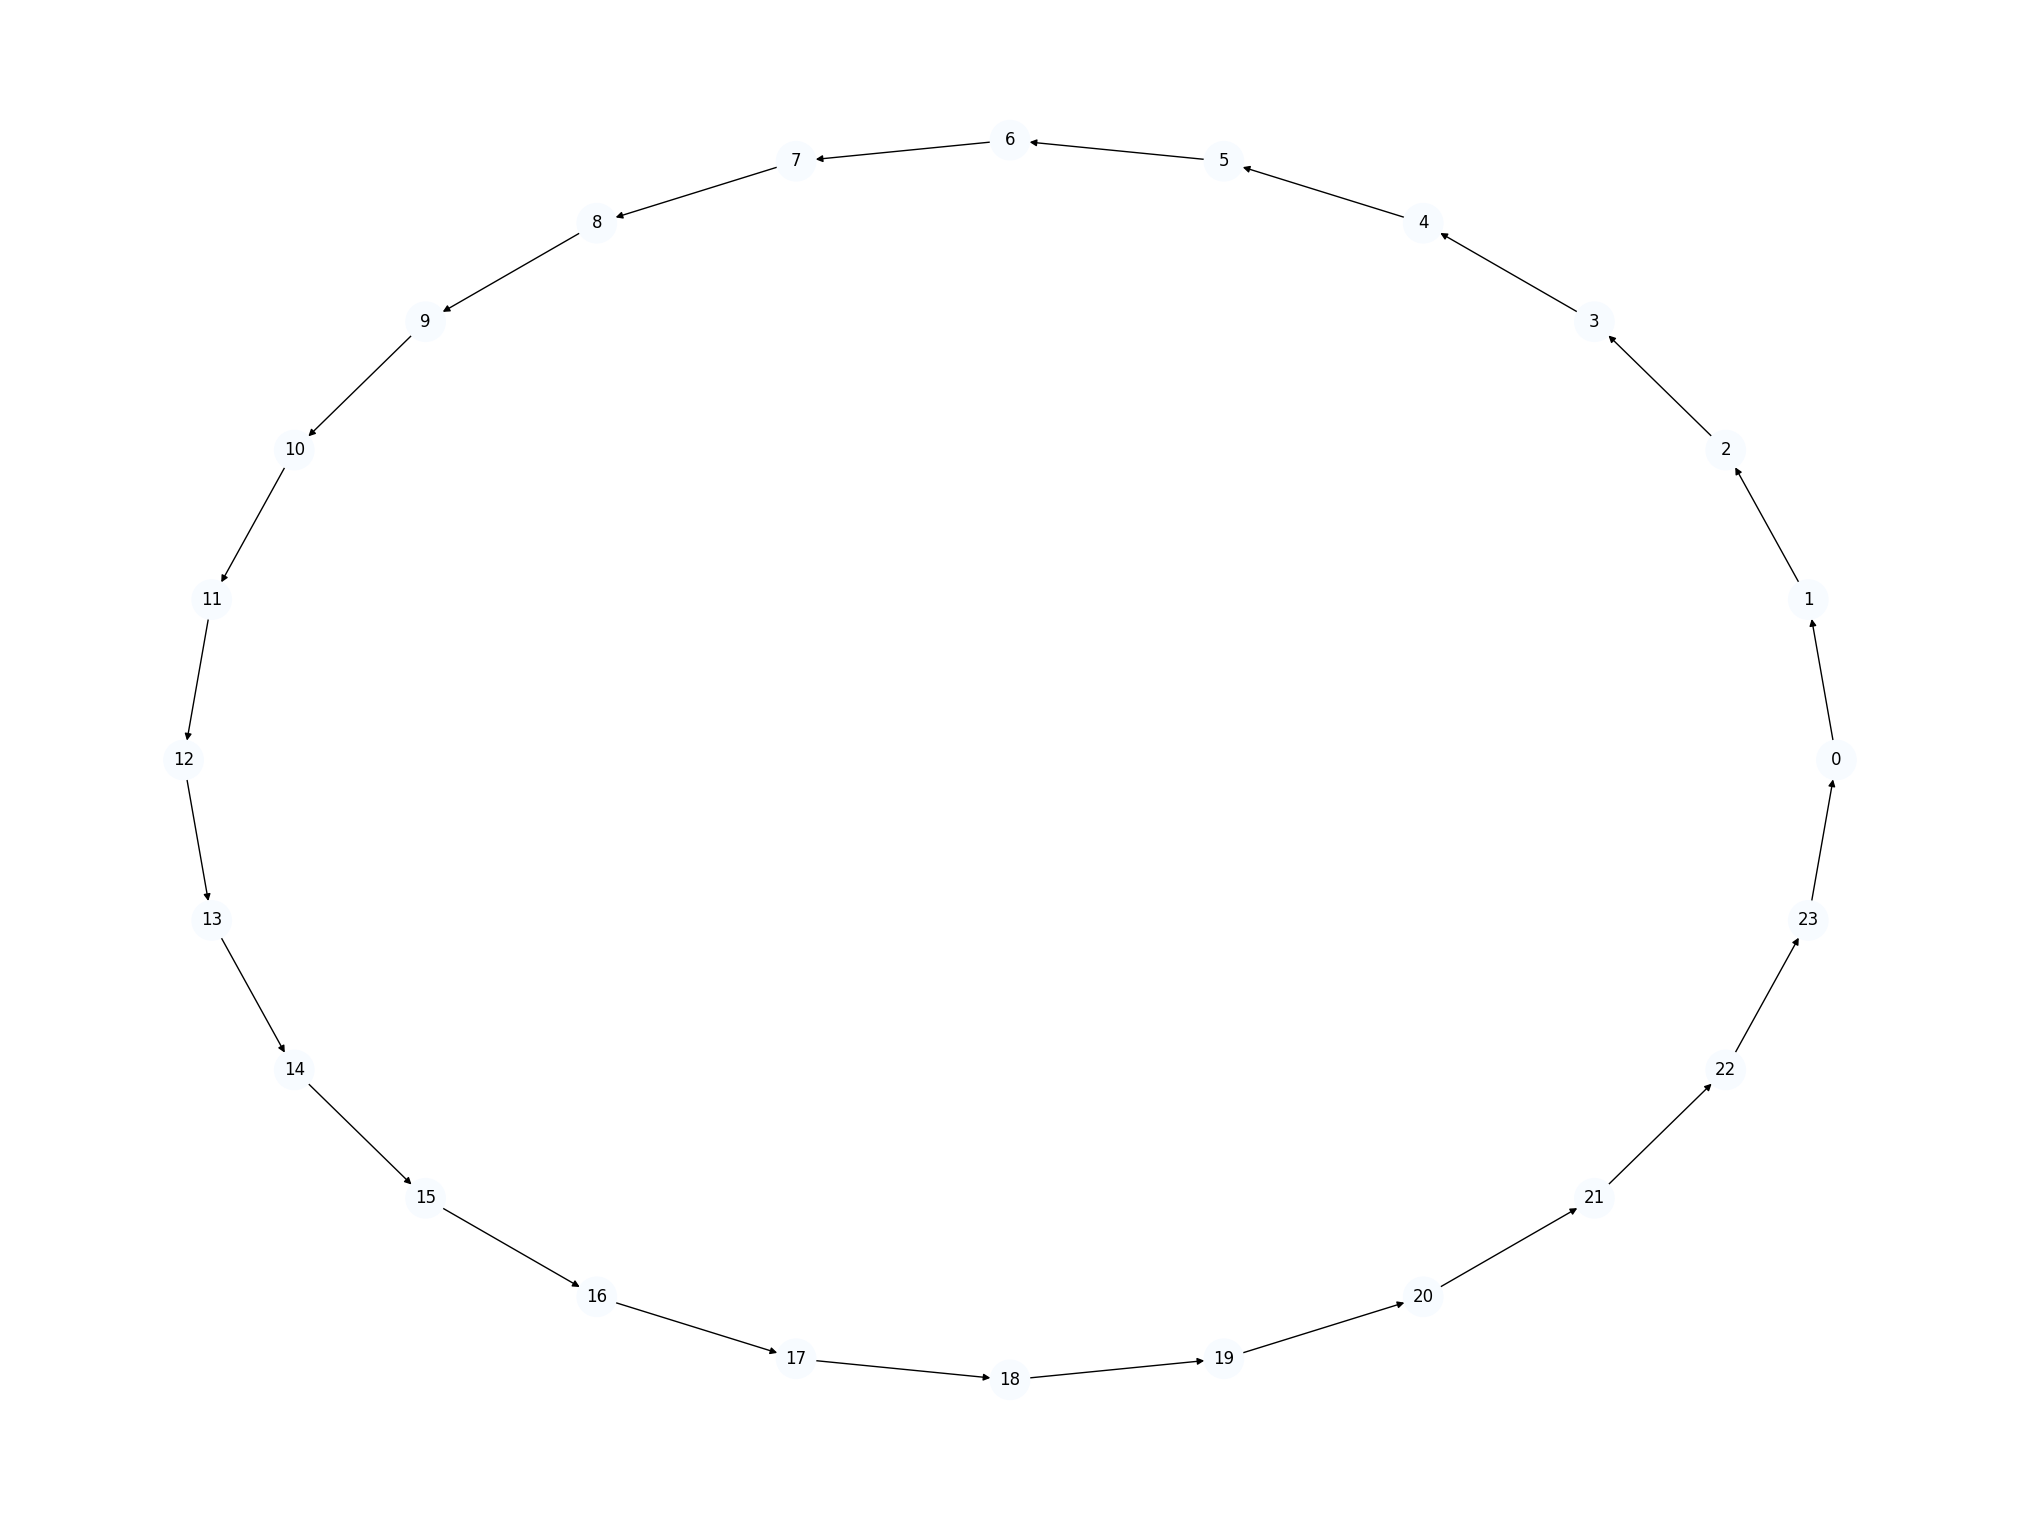

In [6]:
#Graphe cyclique
G = nx.cycle_graph(24, create_using = nx.DiGraph)
rangs_pr = nx.pagerank(G)
pos = nx.circular_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

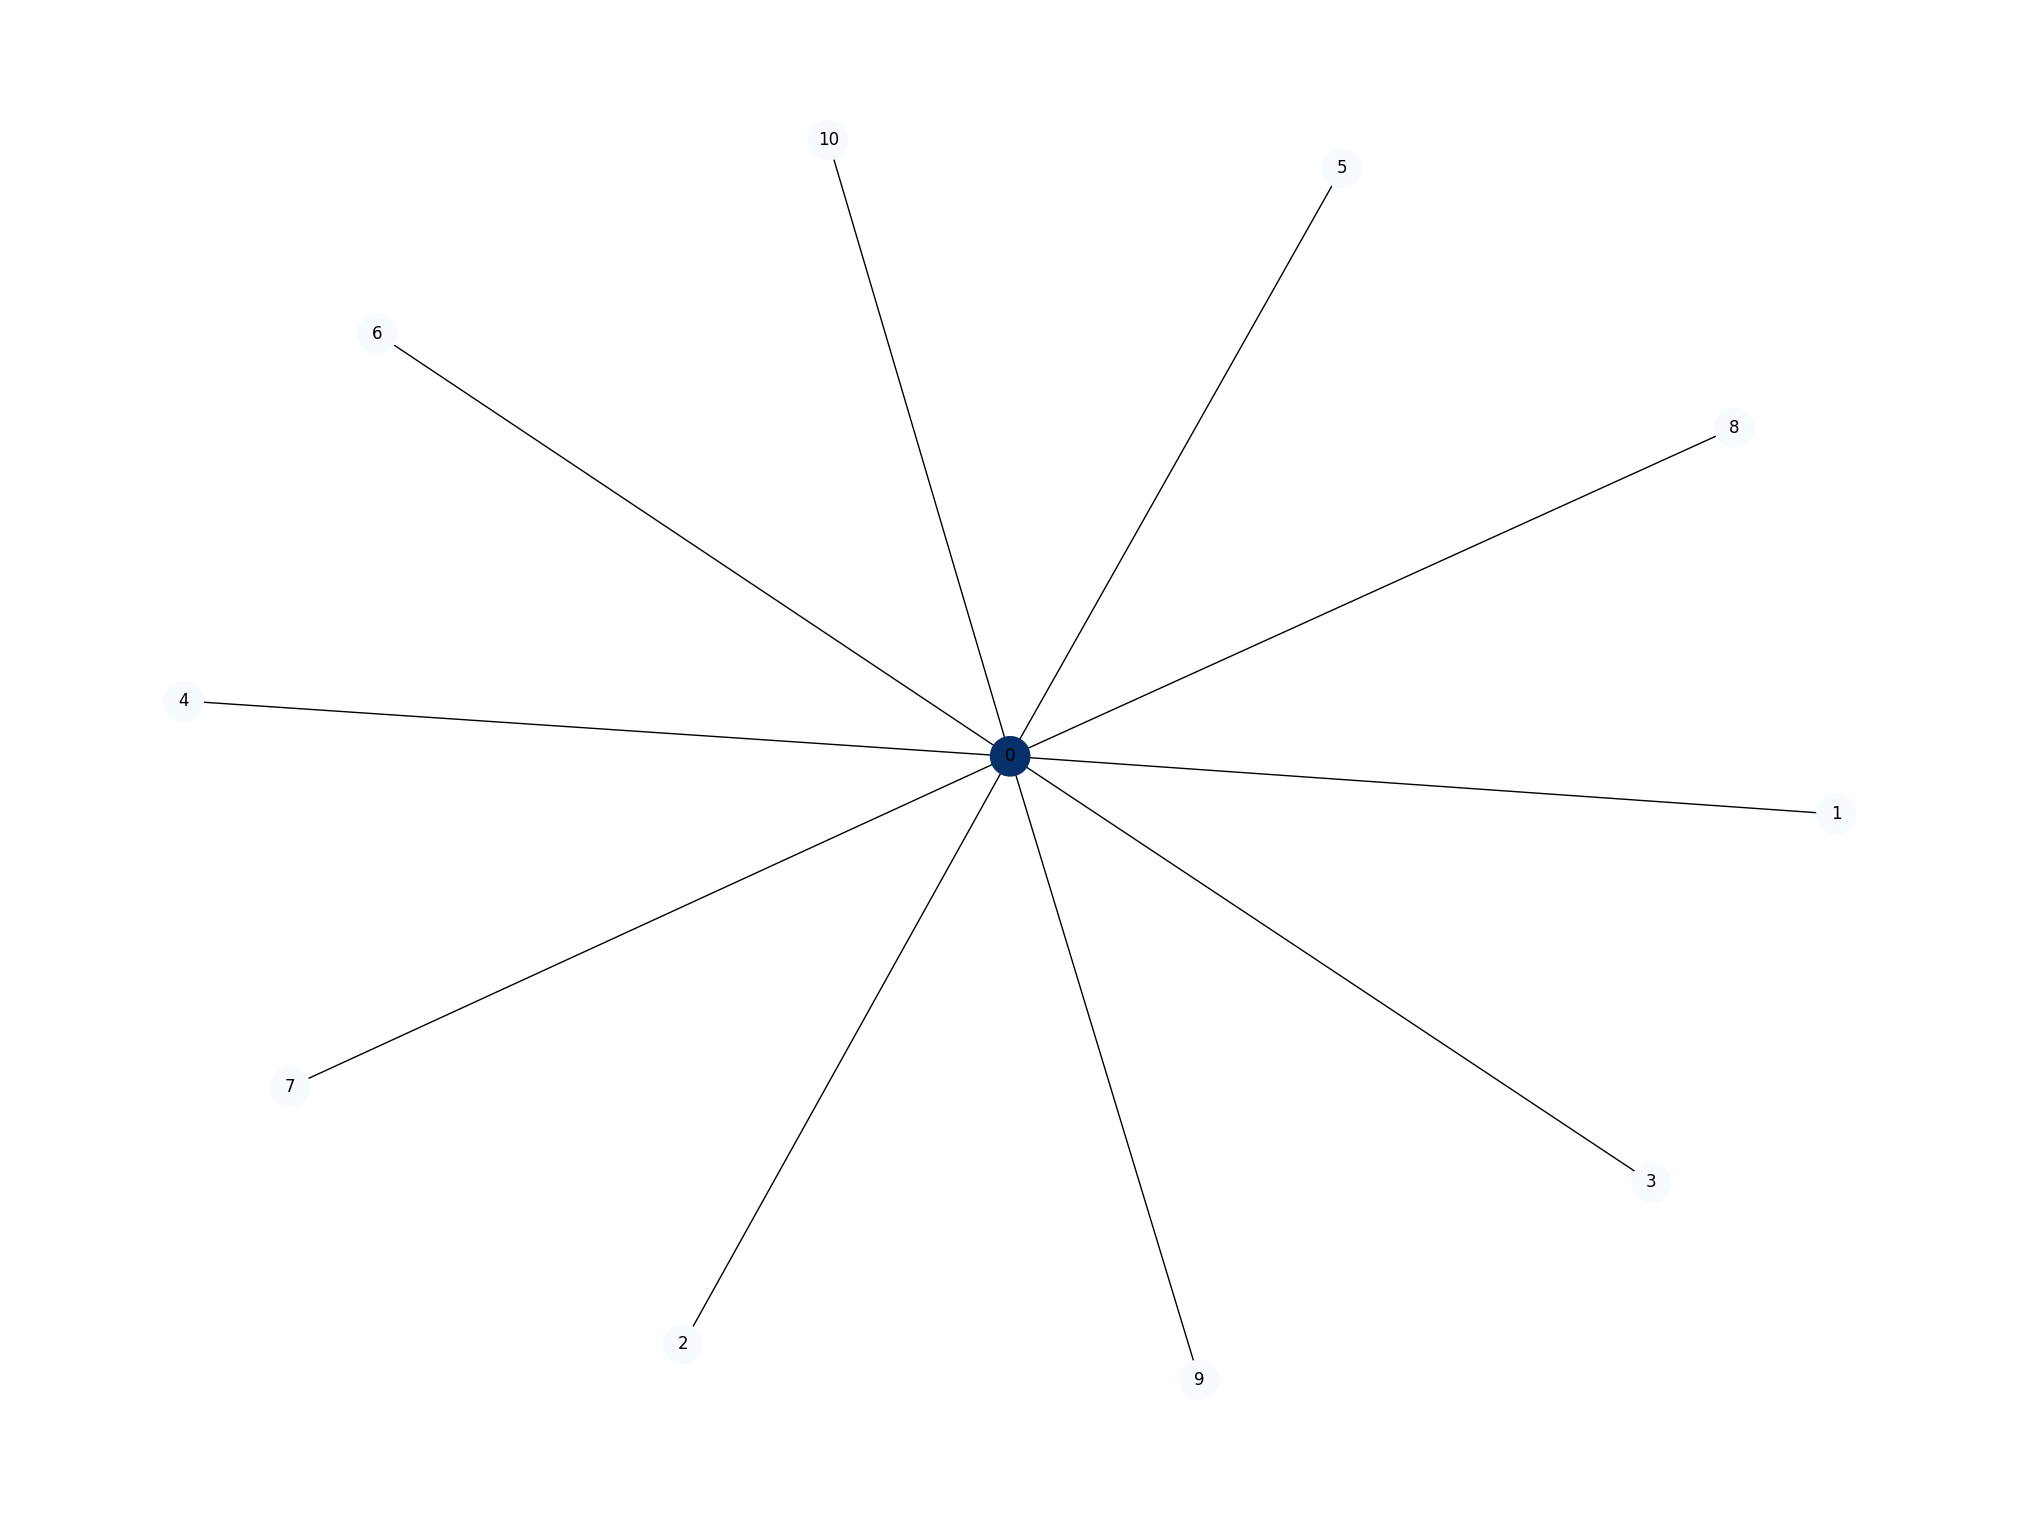

In [7]:
# Graphe étoilé
G=nx.generators.classic.star_graph(10)
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

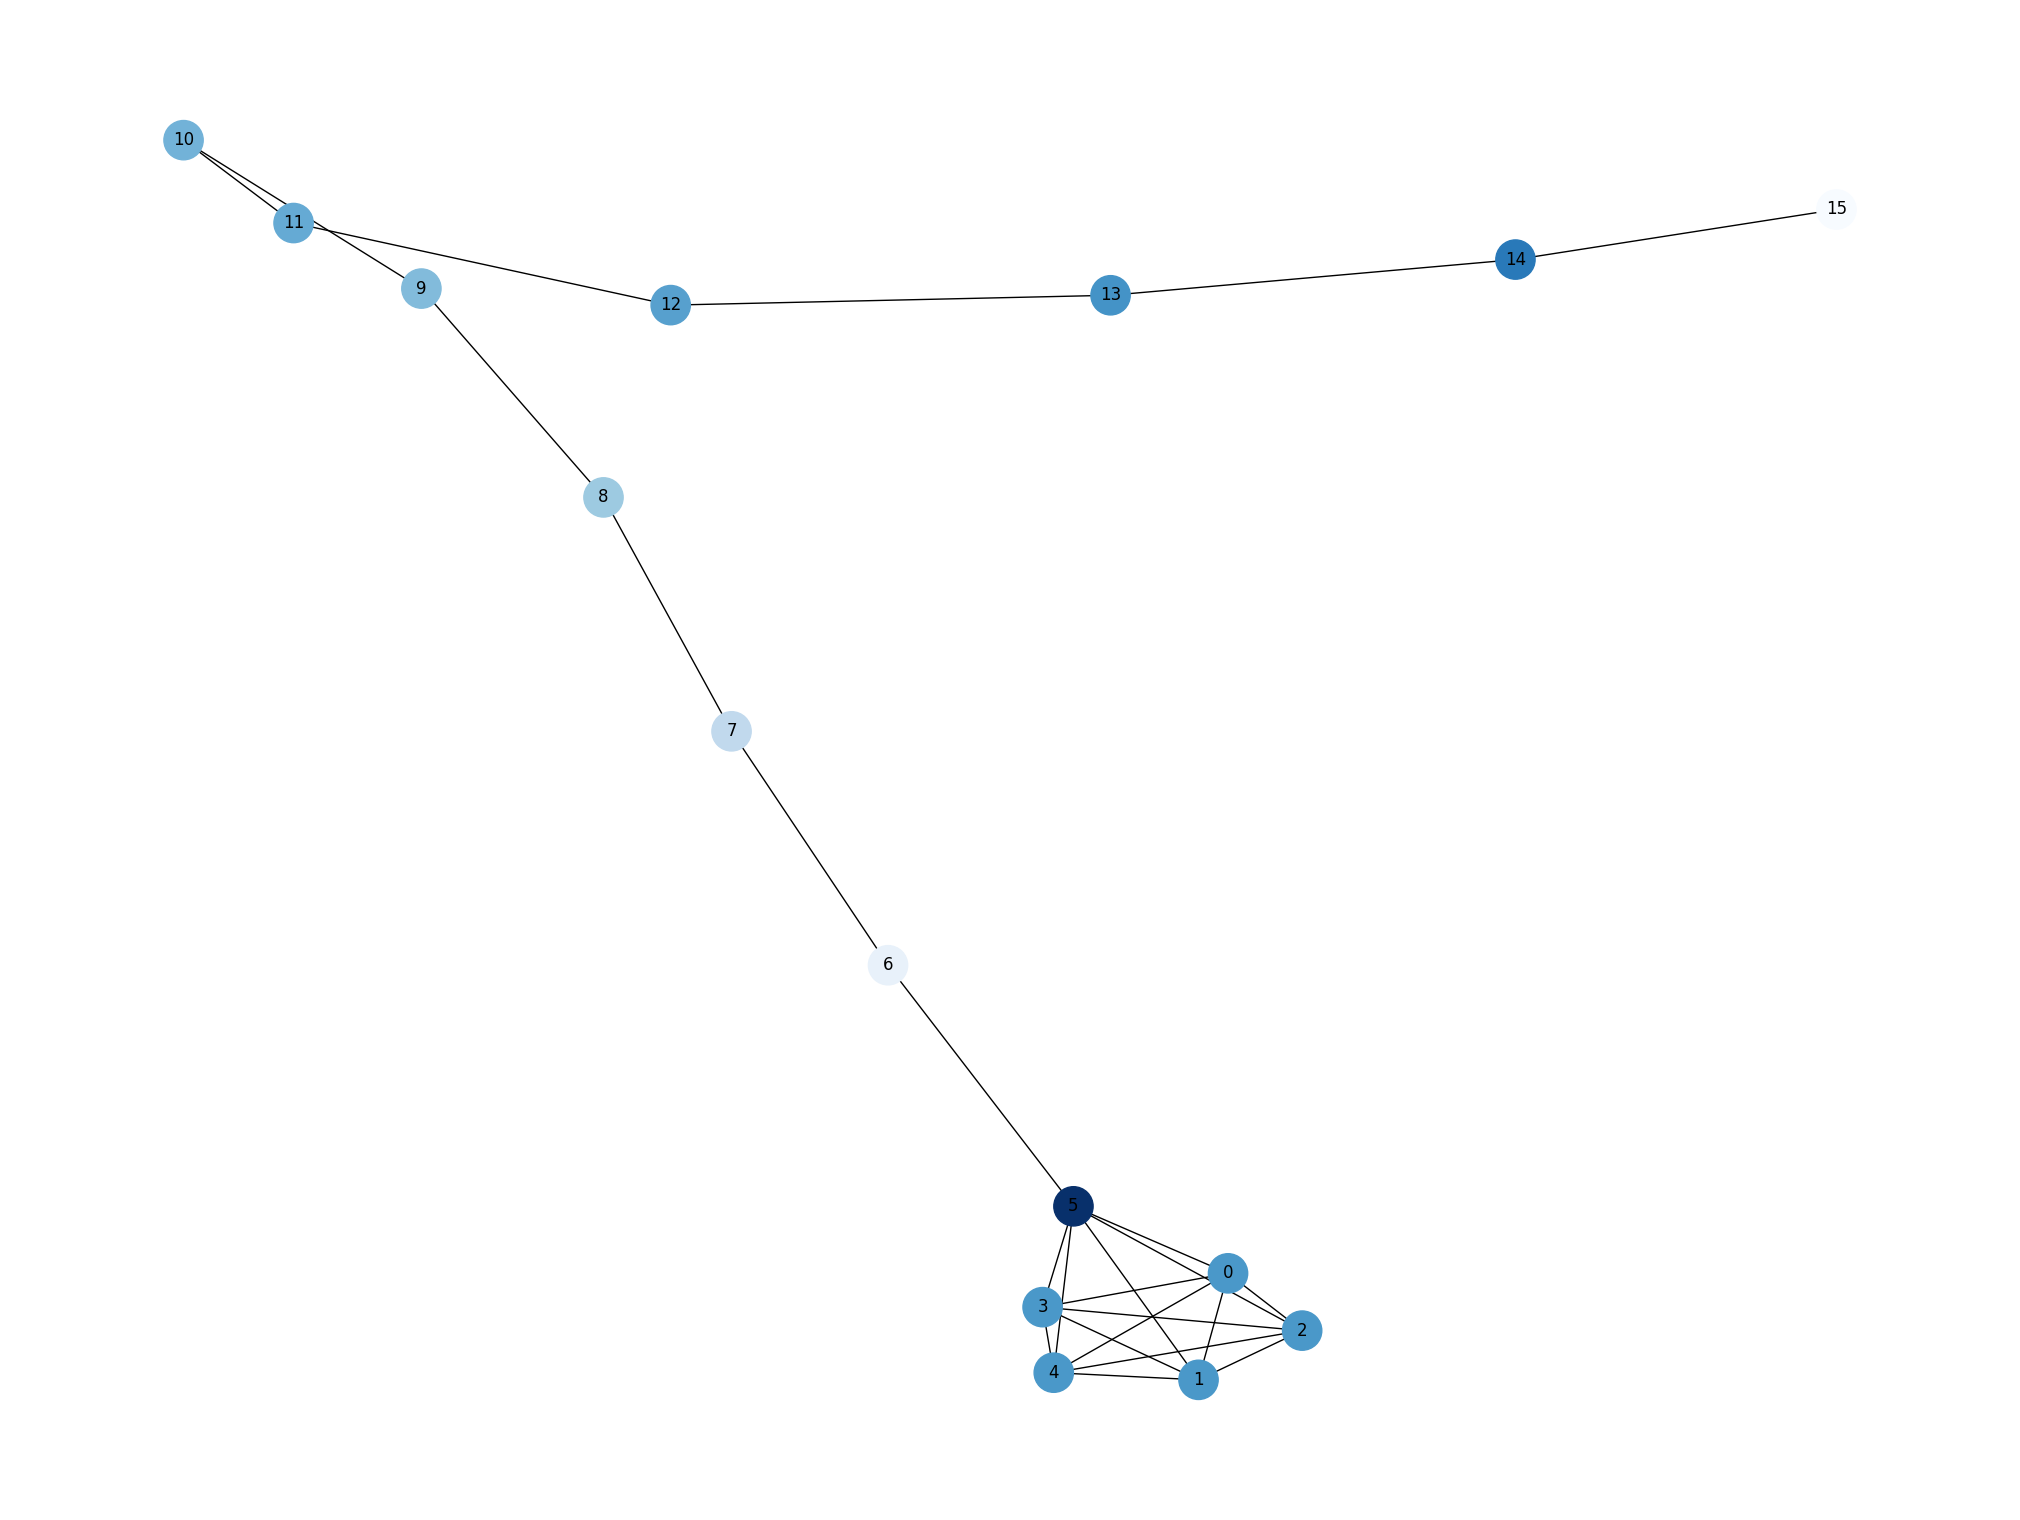

In [8]:
# Graphe sucette
G=nx.generators.classic.lollipop_graph(6,10)
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

Voyons maintenant comment PageRank fonctionne.

# Marche aléatoire et théorème ergodique

On peut construire l'algorithme PageRank à partir d'une marche aléatoire directement sur le graphe :
- On choisit un nœud `node` au hasard dans `G`;
- À chaque itération, on se déplace depuis le noeud `node` courant vers un de ses voisins (dans `G[node]`) via l'un de ses liens sortants tiré uniformément. 

On note à chaque fois le nœud visité.

Si un nœud a beaucoup de liens entrants, vous êtes susceptible de le visiter plus souvent.
Et si ces liens entrants proviennent de nœuds avec de nombreux liens entrants, encore plus.

Cependant, il y a un hic : si un nœud ne contient pas de liens sortants, ou si un ensemble de nœuds forme une boucle sans liens sortants, le marcheur aléatoire se retrouve piégé indéfiniment.

Pour éviter cela, la version native de PageRank modifie légèrement cette marche aléatoire afin qu'à chaque étape, il y ait une certaine probabilité que le marcheur saute vers un nœud aléatoire plutôt que de suivre un lien. On appelle cela une _téléportation_.
Cette probabilité est déterminée par un paramètre, `alpha`, qui est la probabilité de suivre un lien, donc `1-alpha` est la probabilité de faire un saut aléatoire.

Voici une implémentation de cette marche aléatoire sur un multigraphe orienté non-pondéré `G`, et qui incrémente un compteur pour suivre le nombre de fois qu'elle visite chaque nœud. Ici, le fait que `G` est un multigraphe modélise les multiples liens entre les pages Web. Cela permet de ne pas avoir à gérer de poids sur les arrêtes.

On a coder une fonction `marche_aleatoire(G, alpha, iters)` qui renvoie les fréquences de visite de la marche aléatoire sur `G` téléportée avec probabilité `1-alpha`, et simulée pendant `iters` itérations. Ces fréquences sont donc normalisées pour sommer à $1$.

Pour choisir un voisin de `node` aléatoirement, on a utilisé la fonction `np.random.choice(list(G[node]))`. De même, on s'est servi `np.random.choice(list(G))` pour simplifier le code.

In [9]:
def flip(alpha):
    return np.random.random() < alpha

In [10]:
from collections import Counter

def marche_aleatoire(G, alpha=0.85, iters=1000):
    counter = Counter()
    node = np.random.choice(list(G))
    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            node = np.random.choice(list(G))
        
        counter[node] += 1
        
    total = sum(counter.values())
    for key in counter:
        counter[key] /= total

    return counter

Dans `nx.pagerank`, la valeur par défaut de `alpha` est $\alpha = 0,85$. Si tout se passe comme prévu, ces valeurs devraient se rapprocher des résultats du PageRank.

Comparer les scores obtenus de la marche aléatoire avec ceux de `nx.pagerank`.

   PageRank  MarcheAleatoire  Difference
0  0.015000            0.012   -0.003000
1  0.015000            0.024    0.009000
2  0.718904            0.733    0.014096
3  0.015000            0.007   -0.008000
4  0.015000            0.008   -0.007000
5  0.099665            0.087   -0.012665
6  0.027750            0.025   -0.002750
7  0.026794            0.025   -0.001794
8  0.015000            0.018    0.003000
9  0.051887            0.061    0.009113


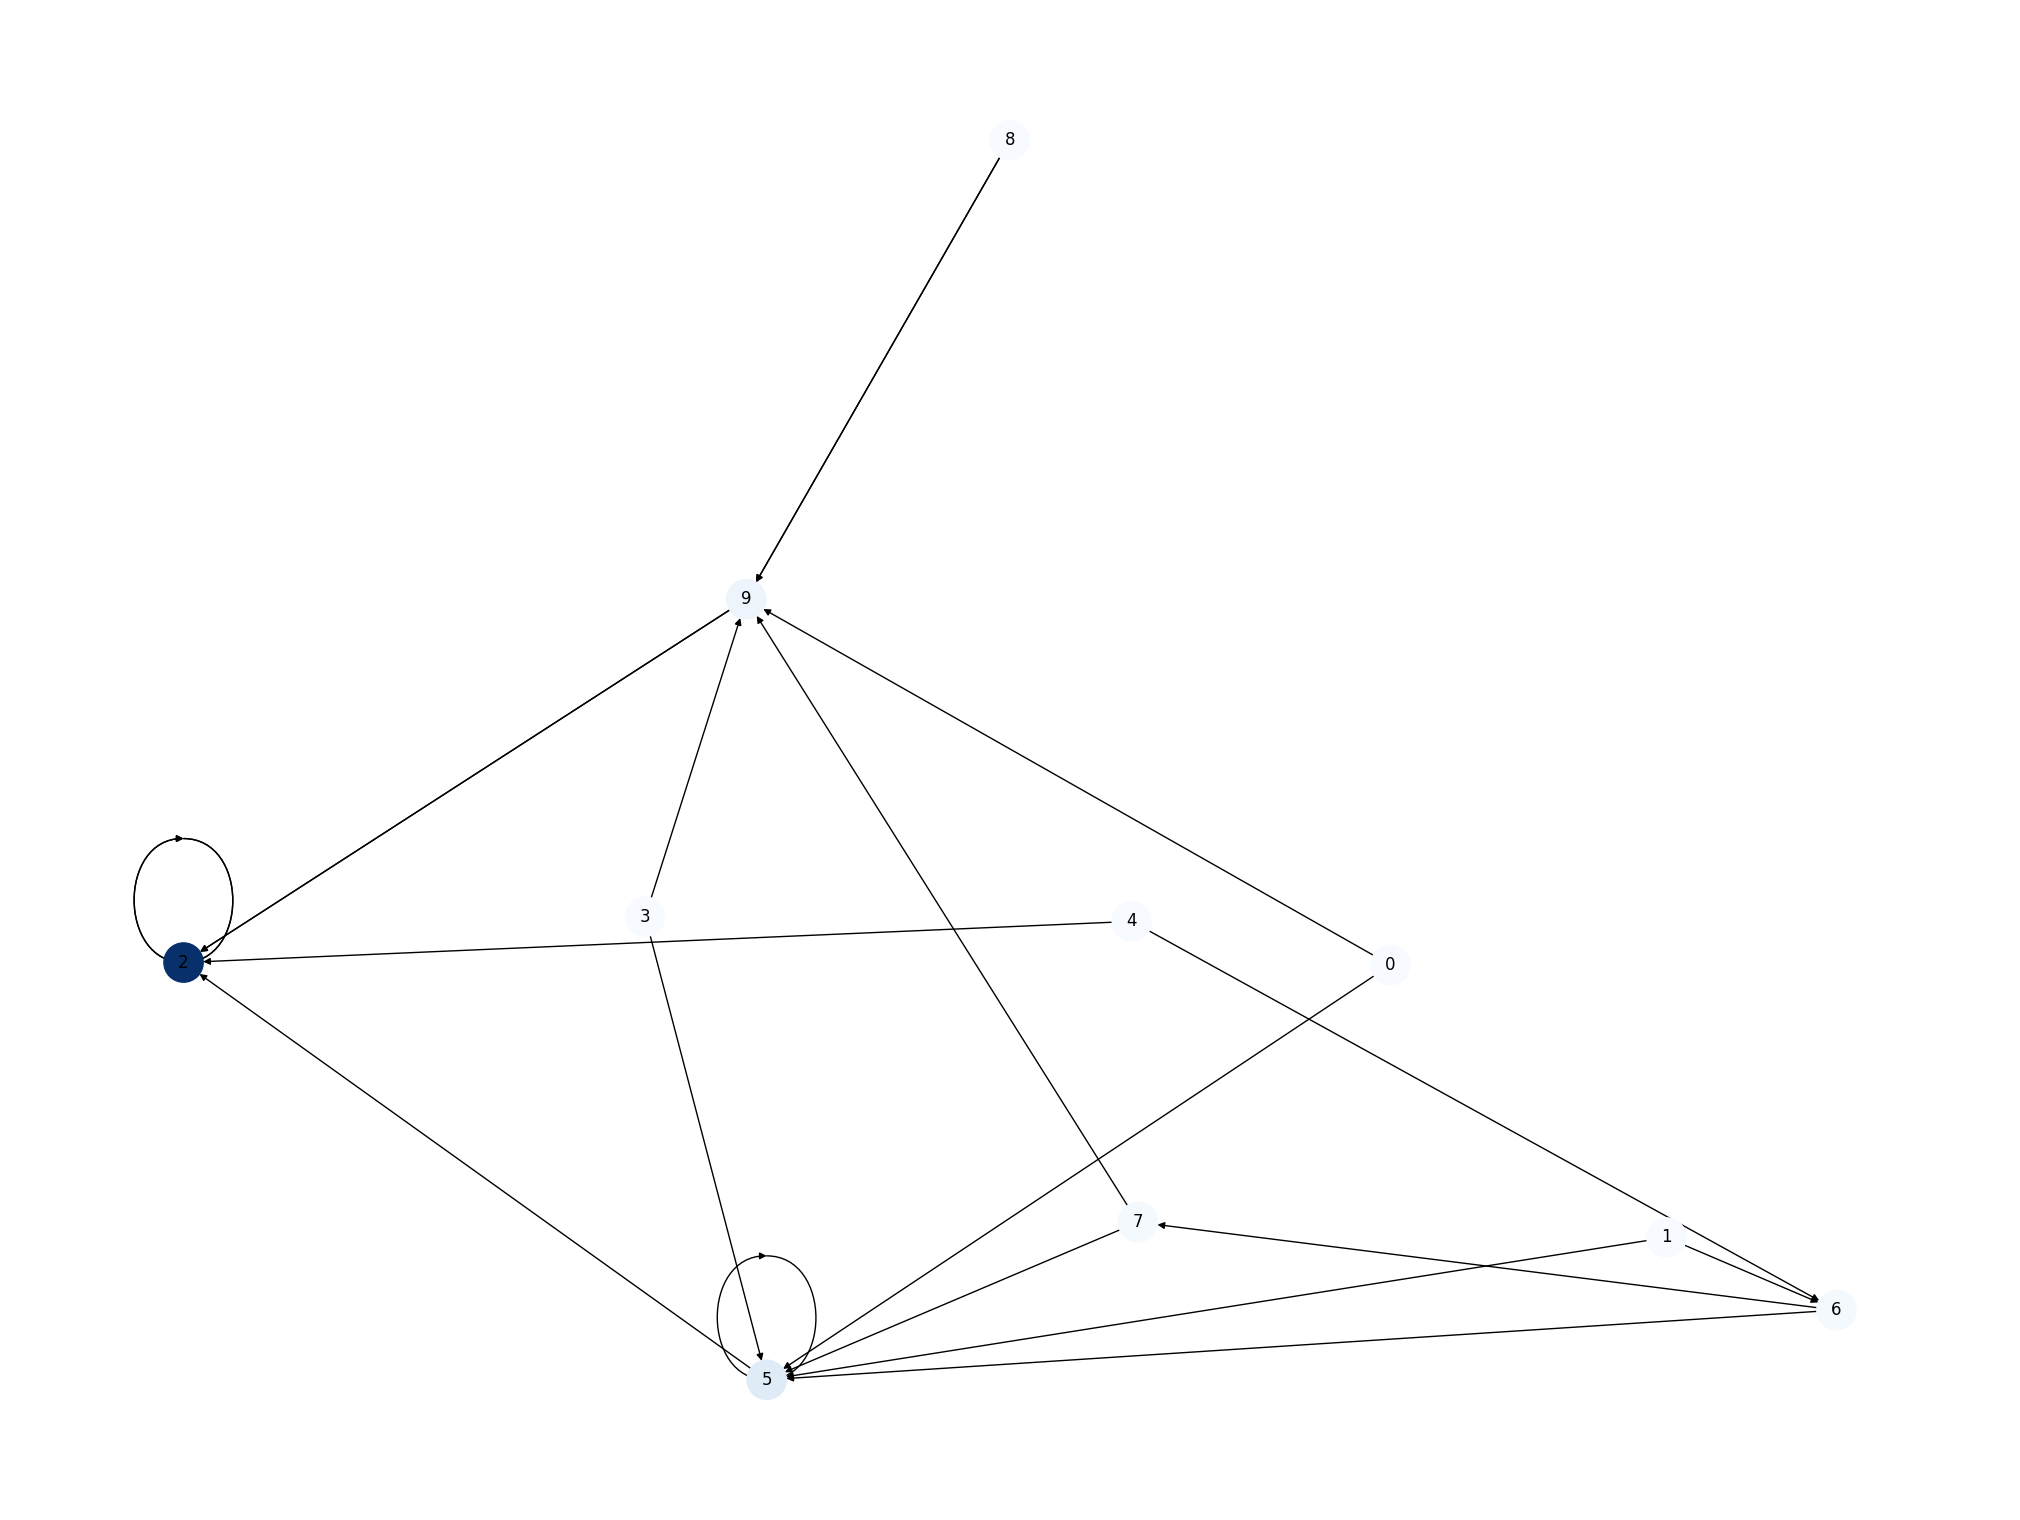

In [11]:
import pandas as pd

G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
rangs_pr = nx.pagerank(G)
rangs_ma = marche_aleatoire(G)

s1 = pd.Series(rangs_pr)
s2 = pd.Series(rangs_ma)

df = pd.DataFrame(dict(PageRank=s1, MarcheAleatoire=s2))
df['Difference'] = df['MarcheAleatoire'] - df['PageRank']
print(df)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

Voici une visualisation de la convergence de cet algorithme en traçant la fréquence d'occupation de chaque noeud en fonction du nombre d'itération. En théorie des probabilités, cette convergence est une conséquence du **théorème ergodique**. 


In [12]:
def trajectoire(G, alpha=0.85, iters=1000):
    traj = []
    node = np.random.choice(list(G)) # next(iter(G))
    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            node = np.random.choice(list(G))
        
        traj += [node]    
    return traj

def trajectoire_to_frequence(traj):
    vals = np.unique(traj)
    iters = len(traj)
    N = len(vals)
    F = np.zeros((N,iters))
    for i in range(N):
        F[i,:] = (traj == vals[i])
        F[i,:] = np.cumsum(F[i,:])/np.array(range(1,iters+1))
    return F

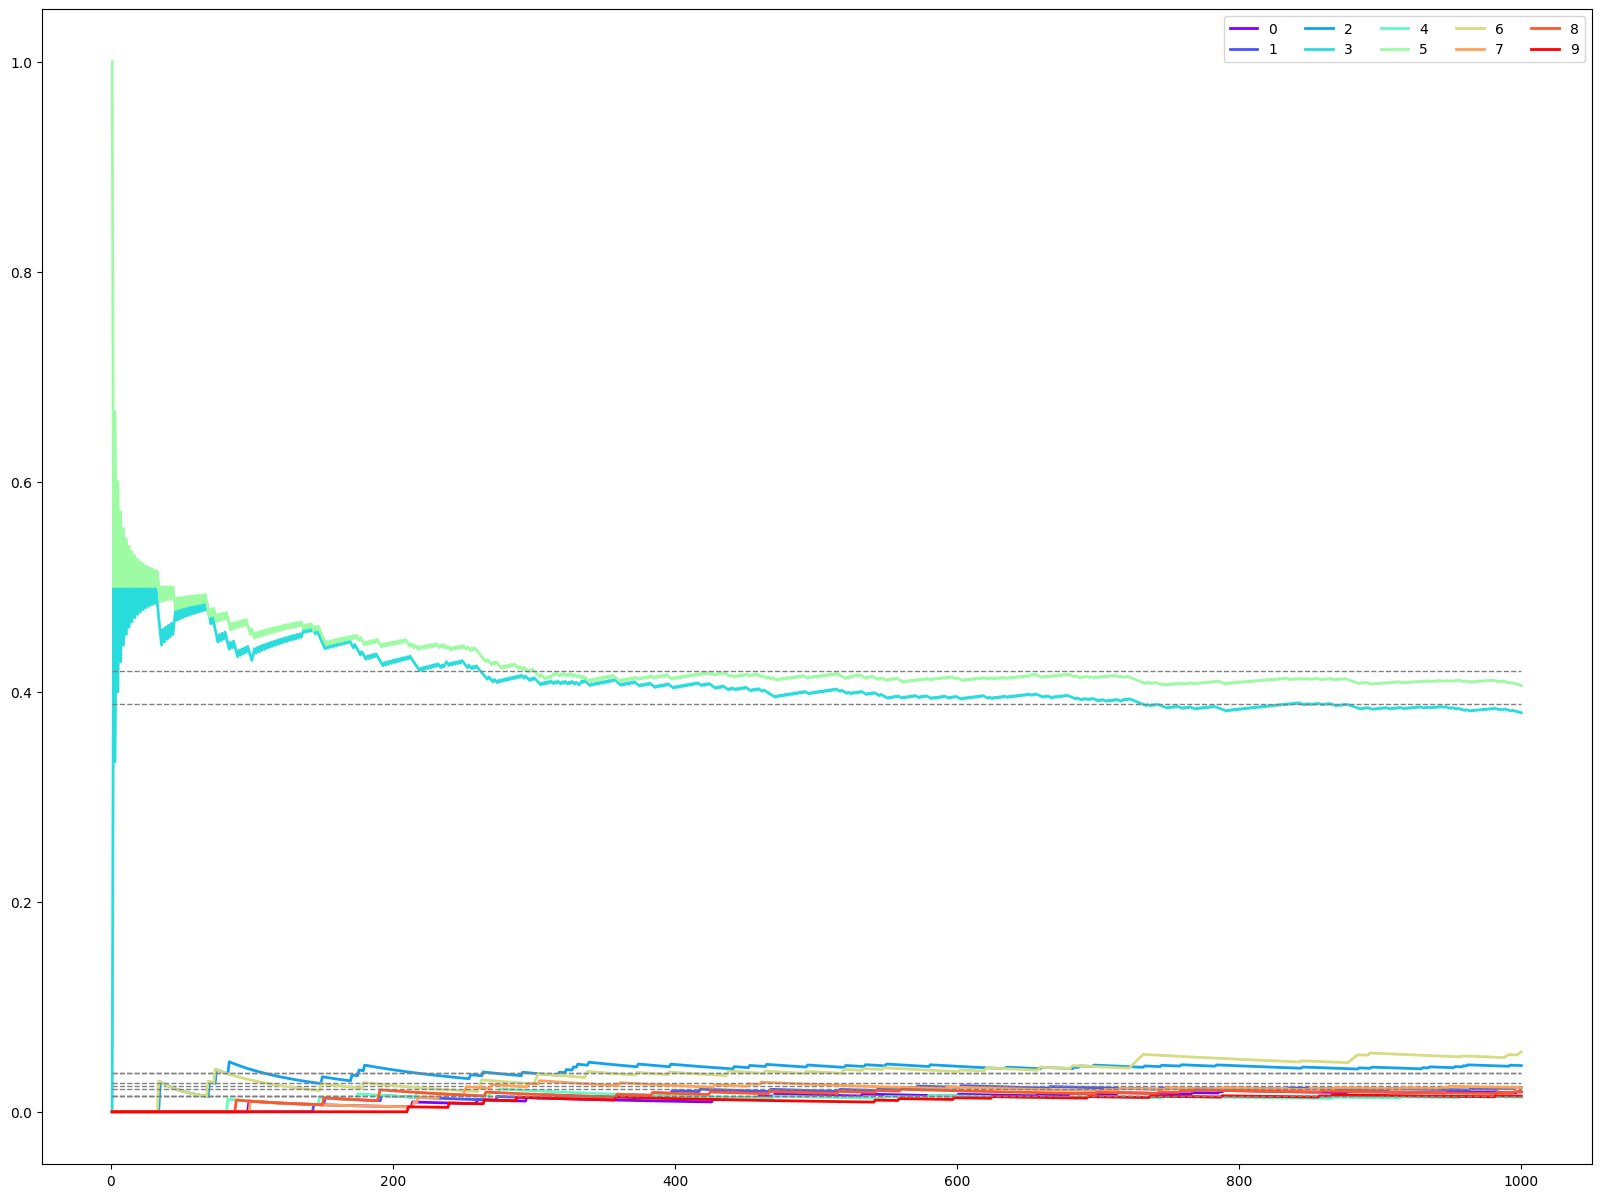

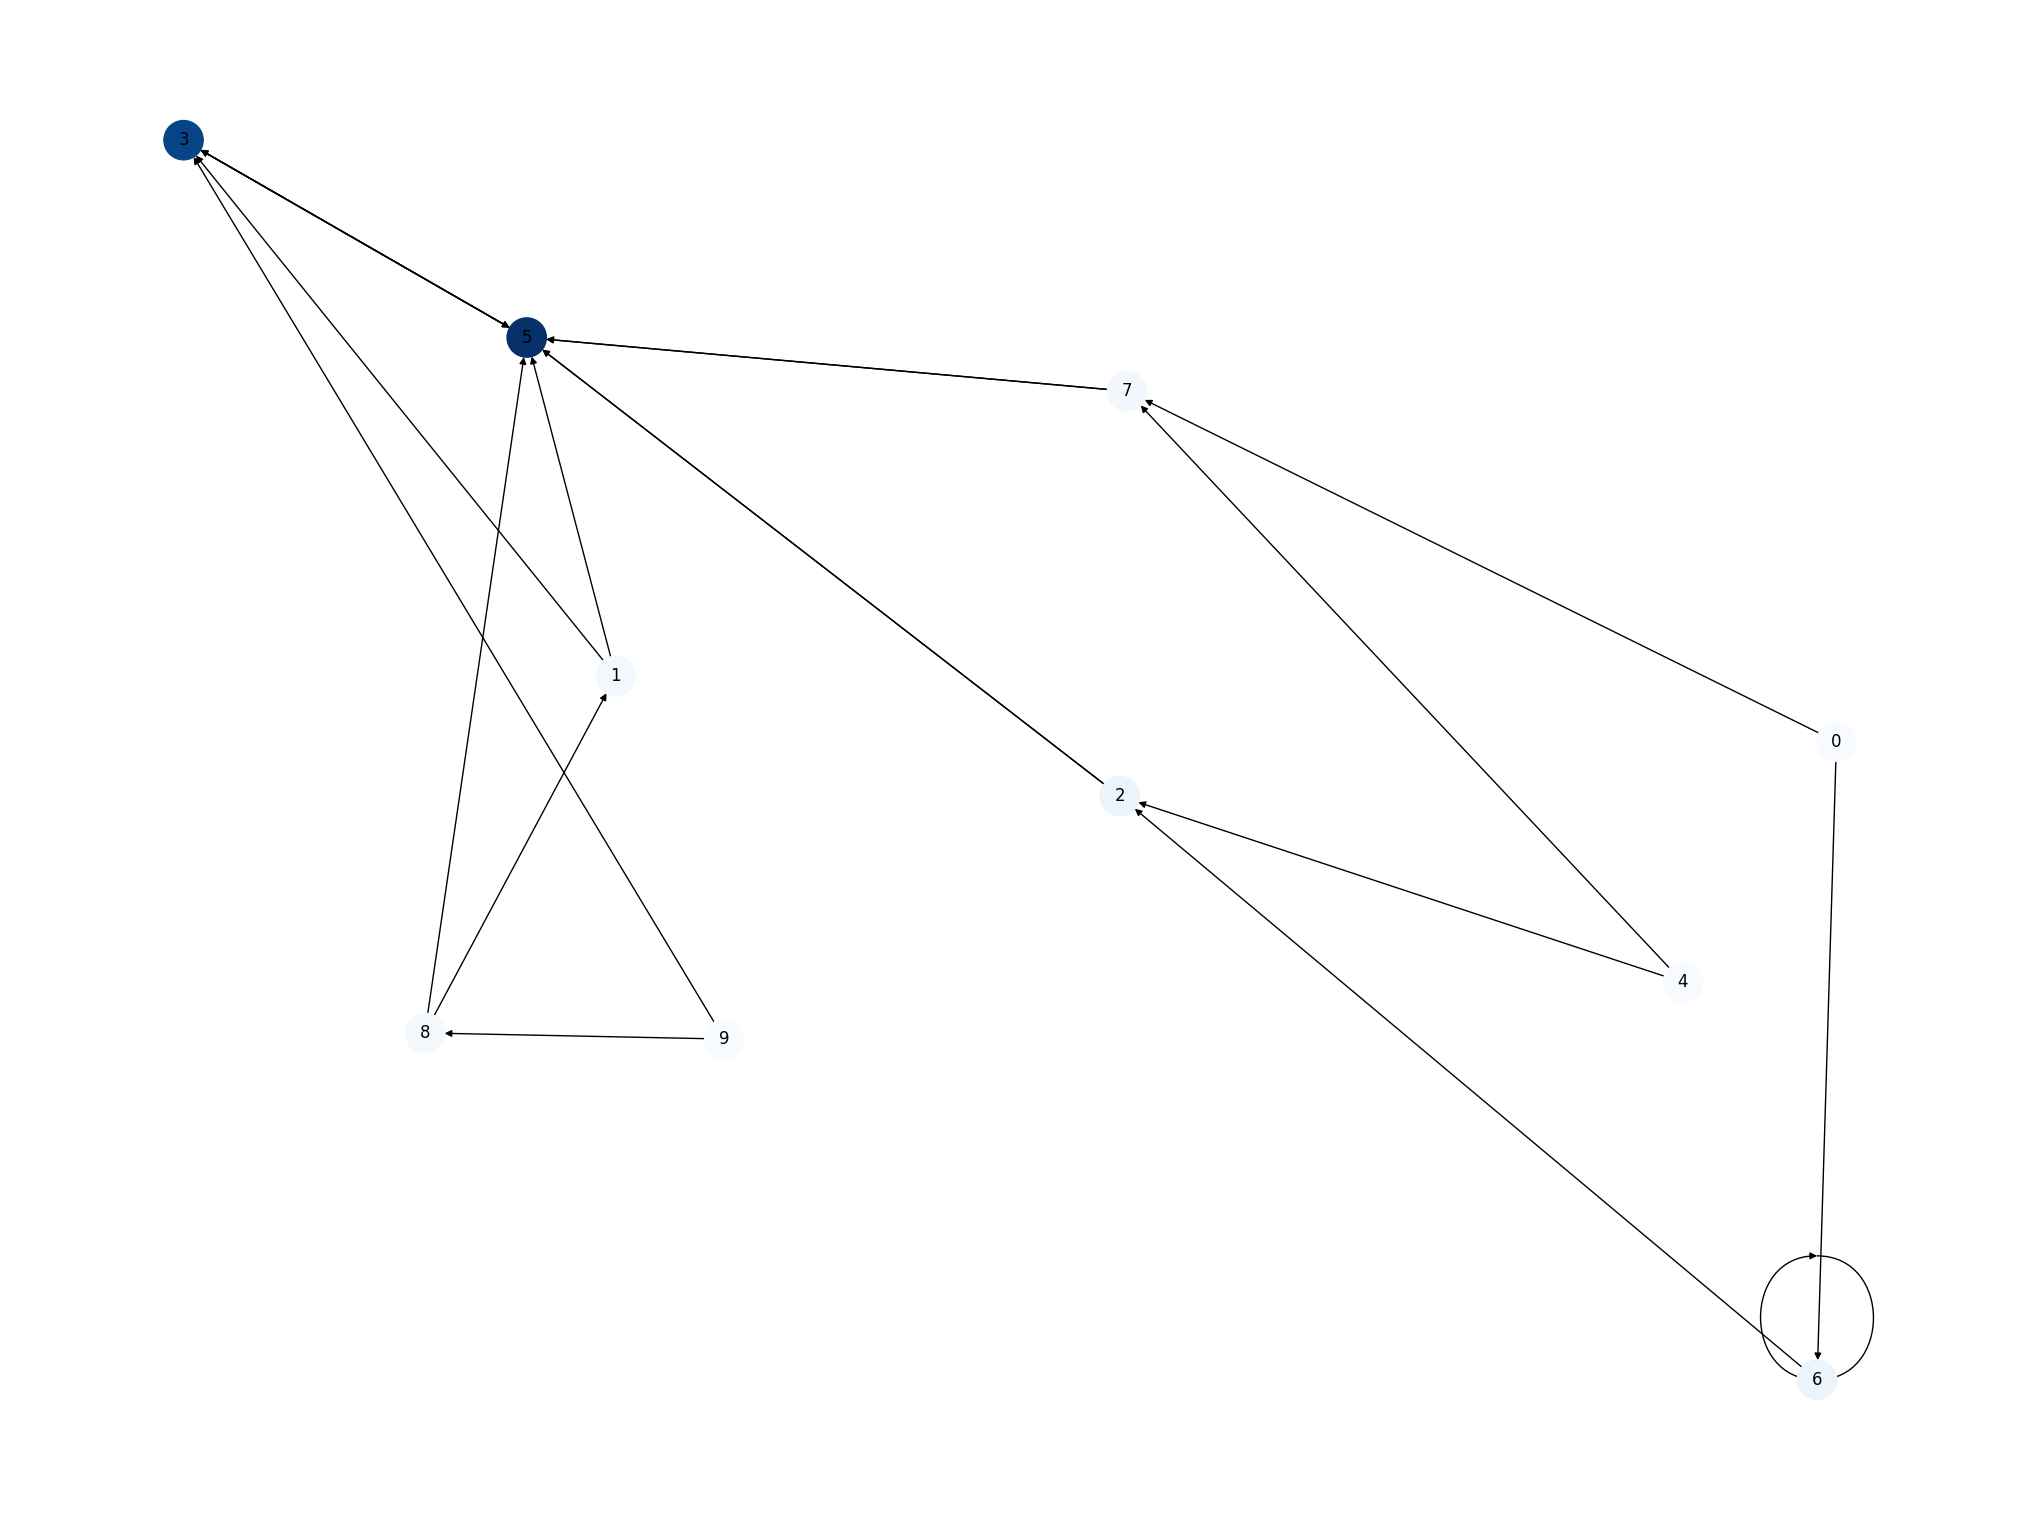

In [13]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

alpha = 0.85
rangs_pr = nx.pagerank(G,alpha)

iters = 1000
x = np.array(range(1,iters+1))
traj = trajectoire(G, alpha, iters)
freq = trajectoire_to_frequence(traj)
vals = np.unique(traj)
N = len(vals)
colors = plt.cm.rainbow(np.linspace(0, 1, N))
for i in range(N):
    plt.plot(x,freq[i,:], label=vals[i], lw=2, color=colors[i])
    plt.plot(x,rangs_pr[vals[i]]*np.ones(iters), lw = 1, linestyle='dashed', color = 'grey')
plt.legend(loc  ='upper right', ncol=N/2)
plt.show()
rangs_pr = nx.pagerank(G)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

Observer l'influence de $\alpha$ sur :
- la limite ;
- la vitesse de convergence vers cette limite.
On s'intéressera en particulier à ce qui se passe lorsque $\alpha = 1$, c'est-à-dire au cas où la marche aléatoire n'est pas téléportée, et au cas où $\alpha = 0$.

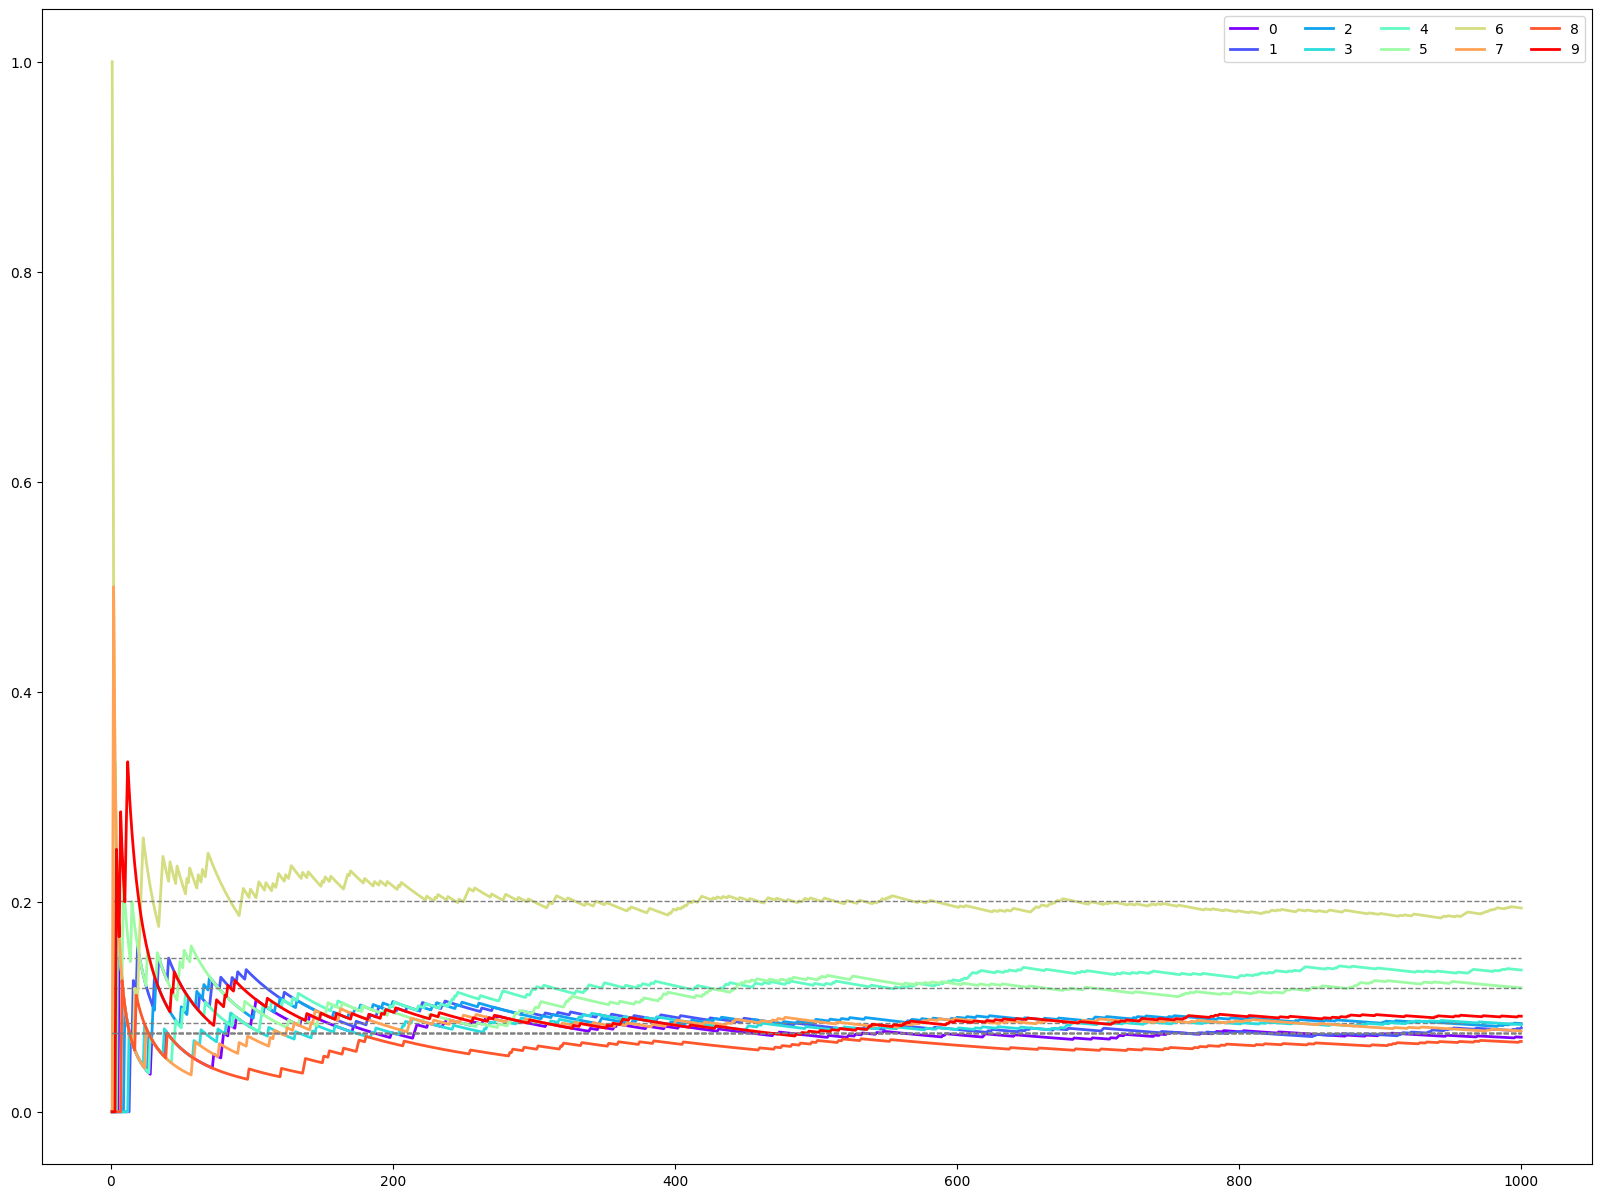

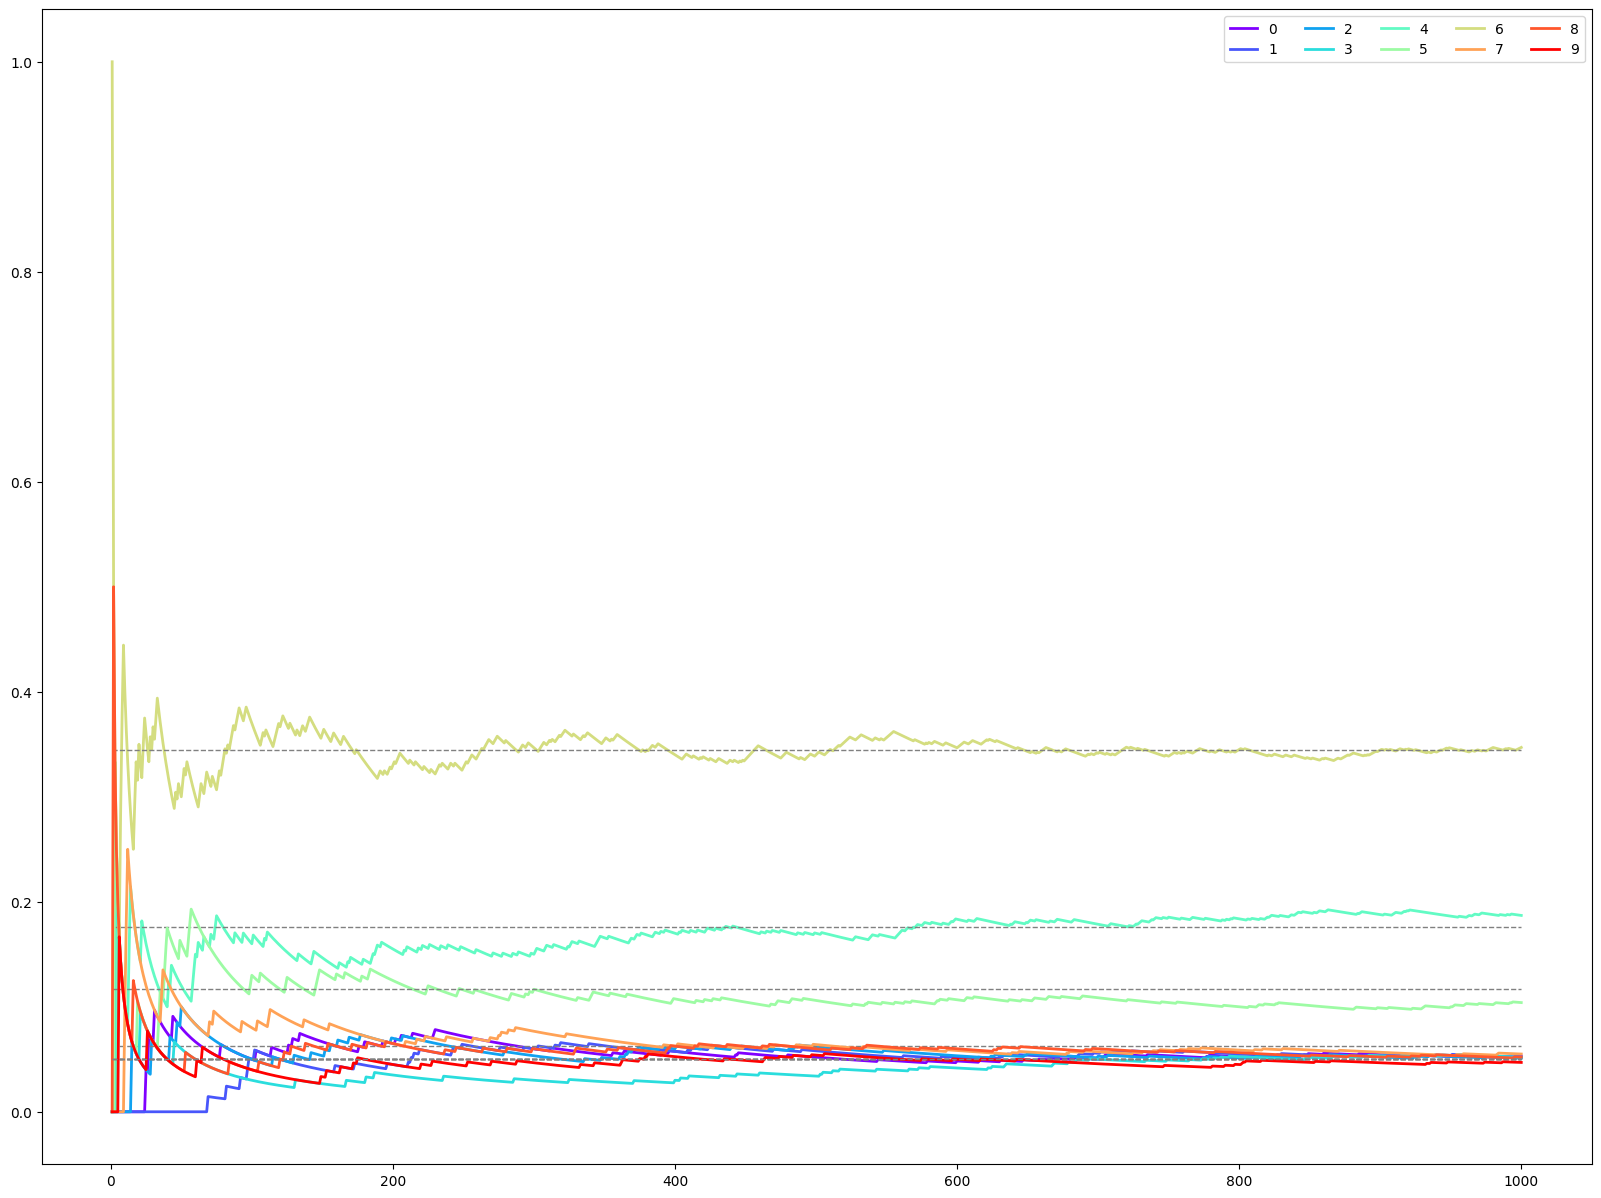

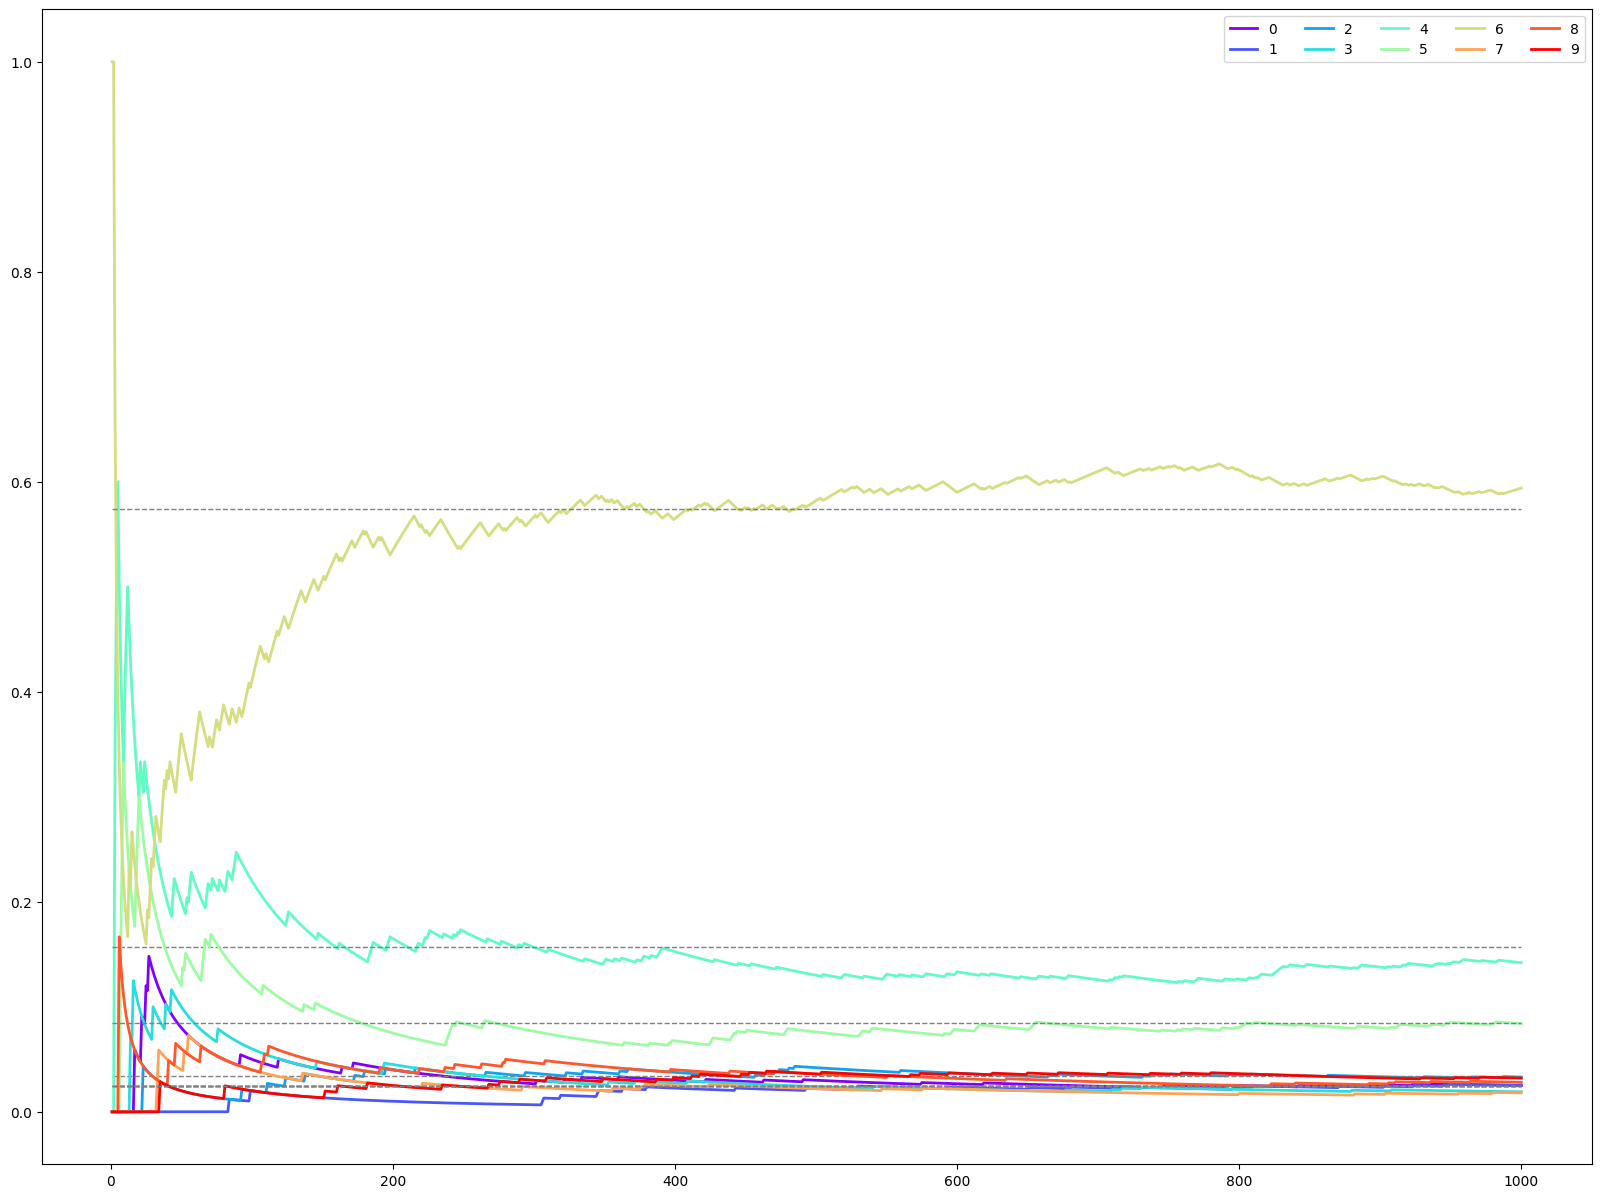

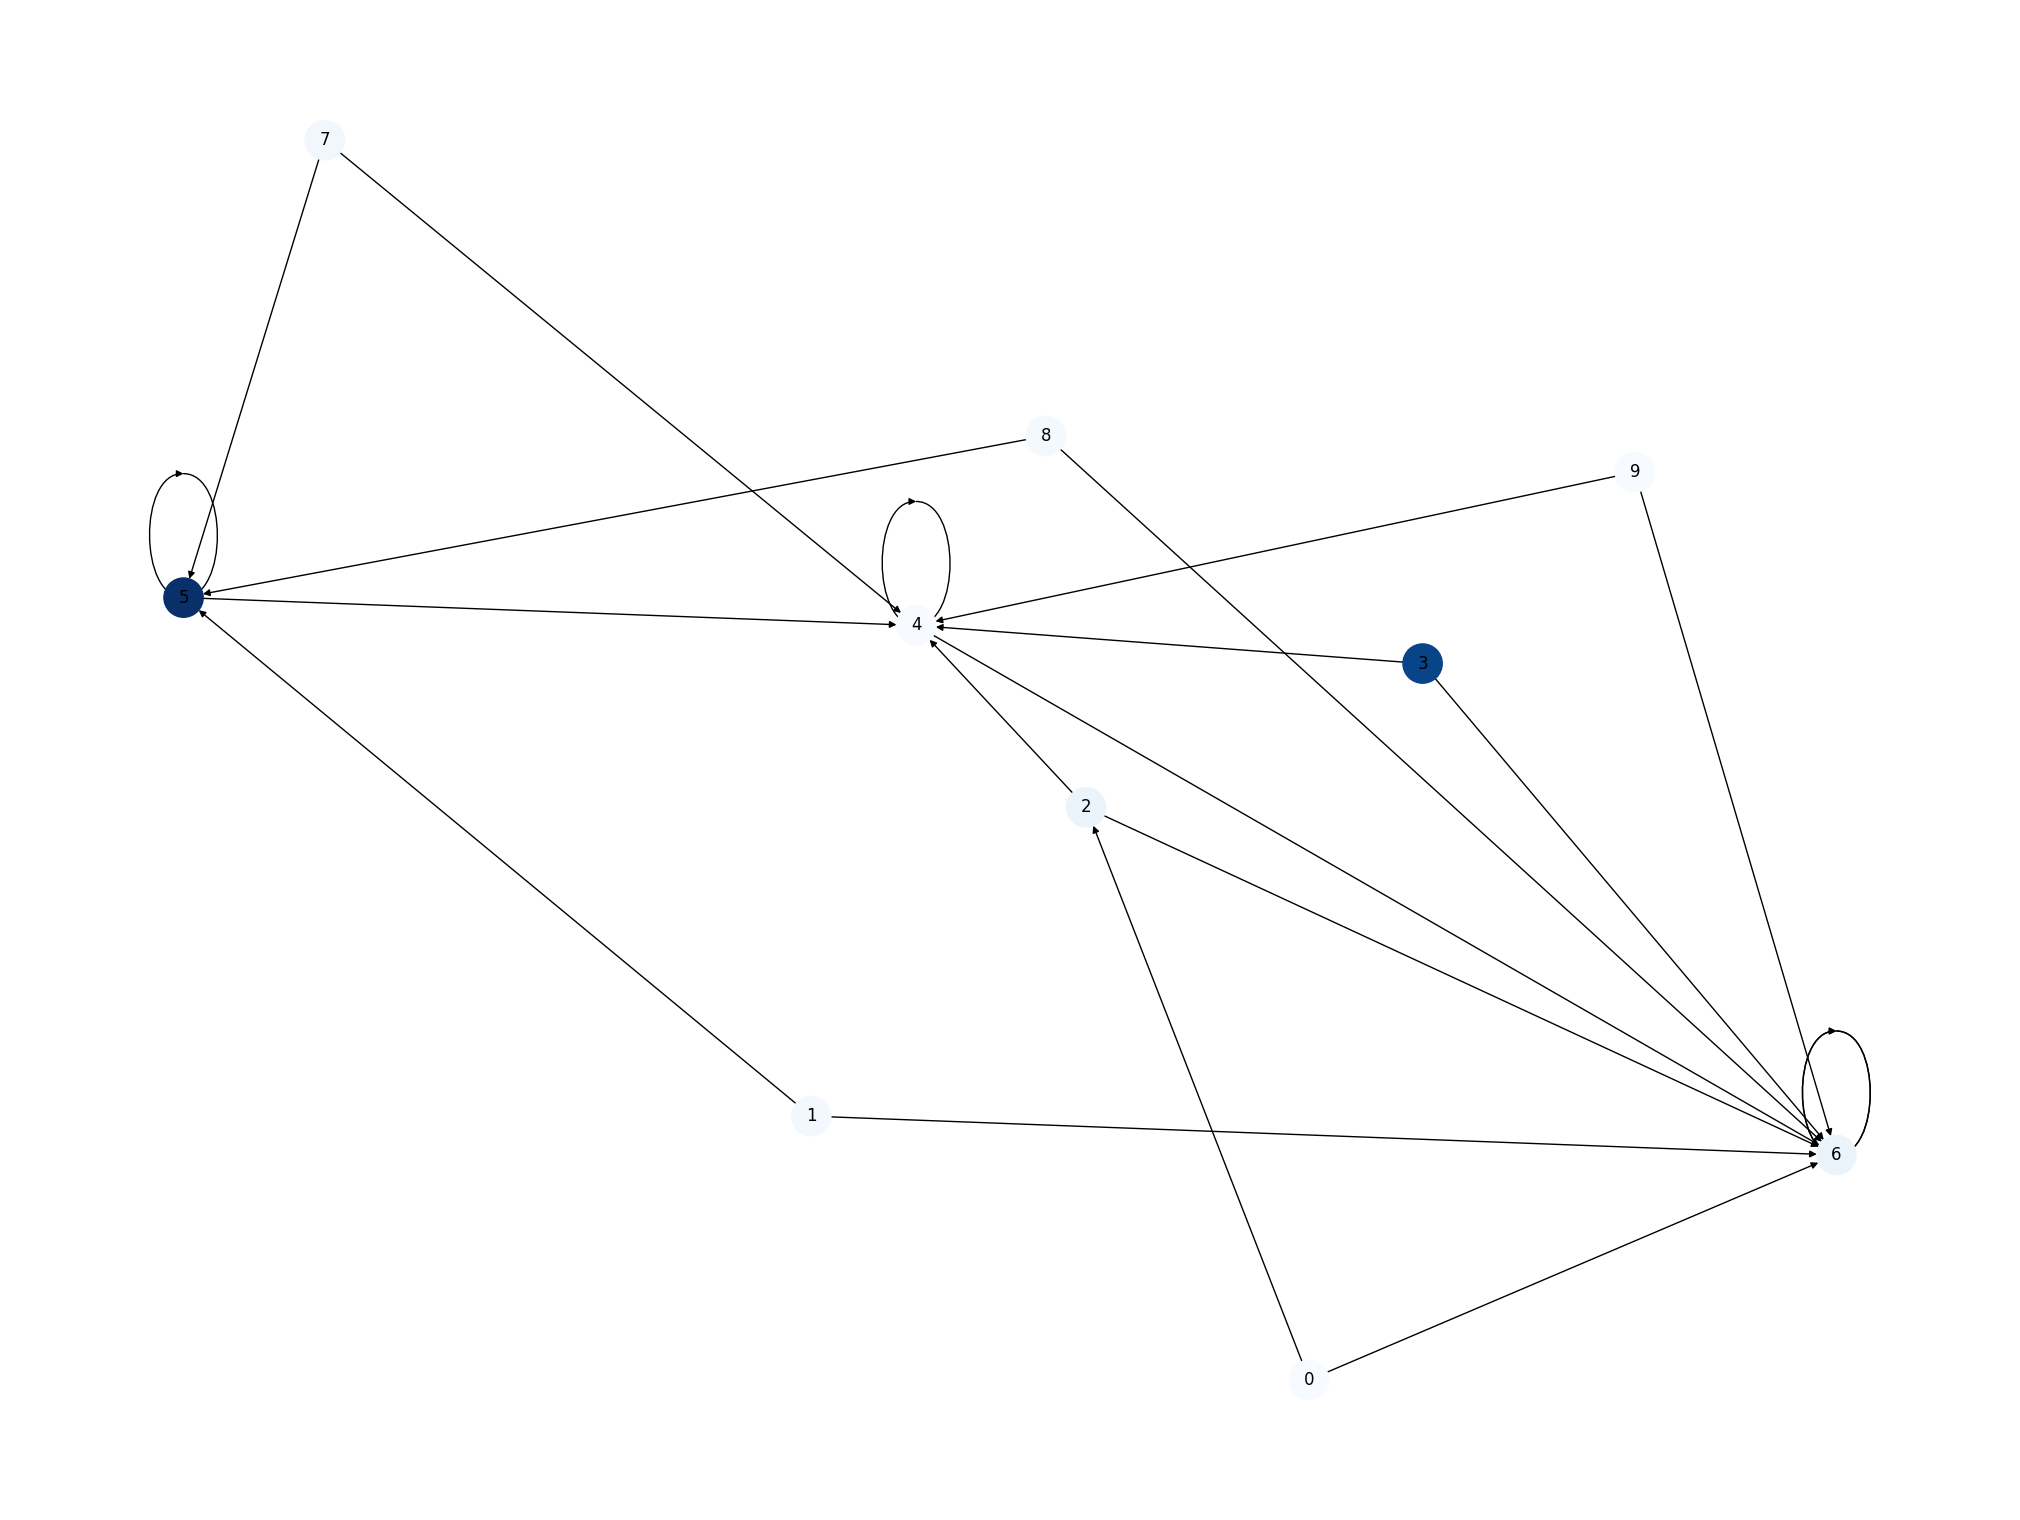

In [14]:
#TODO
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

def PlotGraph(G,alpha):
    rangs_pr = nx.pagerank(G,alpha)
    iters = 1000
    x = np.array(range(1,iters+1))
    traj = trajectoire(G, alpha, iters)
    freq = trajectoire_to_frequence(traj)
    vals = np.unique(traj)
    N = len(vals)
    colors = plt.cm.rainbow(np.linspace(0, 1, N))
    for i in range(N):
        plt.plot(x,freq[i,:], label=vals[i], lw=2, color=colors[i])
        plt.plot(x,rangs_pr[vals[i]]*np.ones(iters), lw = 1, linestyle='dashed', color = 'grey')
    plt.legend(loc  ='upper right', ncol=N/2)
    plt.show()
    rangs_pr = nx.pagerank(G)
    
PlotGraph(G,0.25)
PlotGraph(G,0.5)
PlotGraph(G,0.75)
    
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)


## Matrice d'adjacence

**À vous de jouer !**


L'implémentation de la marche aléatoire de PageRank est conceptuellement simple, mais pas très efficace à calculer.
Une alternative consiste à utiliser la matrice d'adjacence du graphe et de calculer ses vecteurs propres.

Utiliser la fonction `nx.to_numpy_array` pour obtenir la **matrice d'adjacence** `M` du graphe `G`.

In [15]:
#TODO
def ConvertToArray(G):
    return nx.to_numpy_array(G)

print(ConvertToArray(G))
    

[[0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]]


Dans cette matrice, l'élément de la ligne `i`, colonne `j` indique le nombre d'arêtes du nœud 'i' au nœud 'j'.
Si l'on normalise chaque ligne pour qu'elle somme à un, chaque élément du résultat représente la probabilité d'une transition d'un nœud à l'autre.

Normaliser la matrice précédente pour obtenir la **matrice de transition**.

In [16]:
#TODO
def Transition(G):
    G = ConvertToArray(G)
    for i in range(np.shape(G)[0]):
        sum = 0
        for j in range(np.shape(G)[1]):
            sum+=G[i,j]
        if sum !=0:
            for j in range(np.shape(G)[1]):
                G[i,j]= G[i,j]/sum
    return G

print(Transition(G))
            

[[0.  0.  0.5 0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]]


On peut utiliser cette matrice renormalisée pour simuler une marche aléatoire sur `G` avec plusieurs "marcheurs" en même temps. Par exemple, en commençant avec $100$ marcheurs à chaque nœud, représentés par le vecteur $x$ :

In [17]:
def Marcheur(G,marcheur):
    n = len(G)
    x = np.full(n, marcheur)
    return x
print(Marcheur(G,100))

[100 100 100 100 100 100 100 100 100 100]


Dans la matrice de transition $M$, $M_{i,j}$ correspond à la fraction de marcheurs au nœud i qui se déplacent vers le nœud j.

En multipliant $M$ à gauche par $x^\top$, le résultat est un vecteur contenant le nombre de marcheurs à chaque nœud après un pas de temps.

In [18]:
#TODO
def MatriceMarcheur(G,marcheur):
    return np.matmul(Transition(G),np.diag(Marcheur(G,marcheur)))

print(MatriceMarcheur(G,100))

[[  0.   0.  50.   0.   0.   0.  50.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  50.  50.   0.   0.   0.]
 [  0.   0.   0.   0.  50.   0.  50.   0.   0.   0.]
 [  0.   0.   0.   0.  50.   0.  50.   0.   0.   0.]
 [  0.   0.   0.   0.  50.   0.  50.   0.   0.   0.]
 [  0.   0.   0.   0.  50.  50.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.  50.  50.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  50.  50.   0.   0.   0.]
 [  0.   0.   0.   0.  50.   0.  50.   0.   0.   0.]]


En exécutant cette cellule plusieurs fois, constater que `x` converge vers un état stable où le nombre de marcheurs à chaque nœud ne change pas beaucoup d'un pas de temps à l'autre.

Cependant, vous remarquerez peut-être que certains nœuds perdent tous leurs marcheurs.

Pour palier ce problème, on peut ajouter des téléportations aléatoires, en créant la matrice de transition $P$ associée au graphe complet. Celle-ci inclut donc les transitions de tous les nœuds vers tous les autres nœuds avec une probabilité égale.

Créer la matrice $P$.

In [19]:
#TODO
def MarcheurAleatoire(G,marcheur):
    return np.full((np.shape(G)[0],np.shape(G)[0]),1/np.shape(G)[0])

print(MarcheurAleatoire(G,100))

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


Créer la matrice de transition `GM` correspondant à la marche aléatoire suivant, à chaque étape, une arrête de `G` avec probabilité `1- alpha`, et une arrête du graphe complet avec probabilité `alpha`.

In [20]:
#TODO
def MatriceMarcheurAleatoire(G,marcheur,alpha):
    return alpha*MatriceMarcheur(G,marcheur)+(1-alpha)*MarcheurAleatoire(G,marcheur)

print(MatriceMarcheurAleatoire(G,100,0.85))


[[1.5000e-02 1.5000e-02 4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02
  4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01
  4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01 1.5000e-02
  4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01 1.5000e-02
  4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01 1.5000e-02
  4.2515e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01 4.2515e+01
  1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02
  8.5015e+01 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01 4.2515e+01
  1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02]
 [1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 1.5000e-02 4.2515e+01
  4.2515e+01

La matrice `GM` est appelée **Google matrix**. Recommençons donc les itérations du produit avec un nombre égal de marcheurs sur tous les nœuds, et $10$ pas de temps.

In [21]:
#TODO
MatriceMarcheurAleatoire(G,10,0.85)

array([[0.015, 0.015, 4.265, 0.015, 0.015, 0.015, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 0.015, 4.265, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 0.015, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 0.015, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 0.015, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 4.265, 0.015, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 8.515, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 4.265, 0.015, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 0.015, 4.265, 4.265, 0.015, 0.015,
        0.015],
       [0.015, 0.015, 0.015, 0.015, 4.265, 0.015, 4.265, 0.015, 0.015,
        0.015]])

Si nous normalisons le vecteur `x` obtenu pour que ses coefficients somment à un, le résultat doit se rapprocher du résultat obtenu avec PageRank.

Comparer le résultat avec la sortie de `nx.pagerank`. 

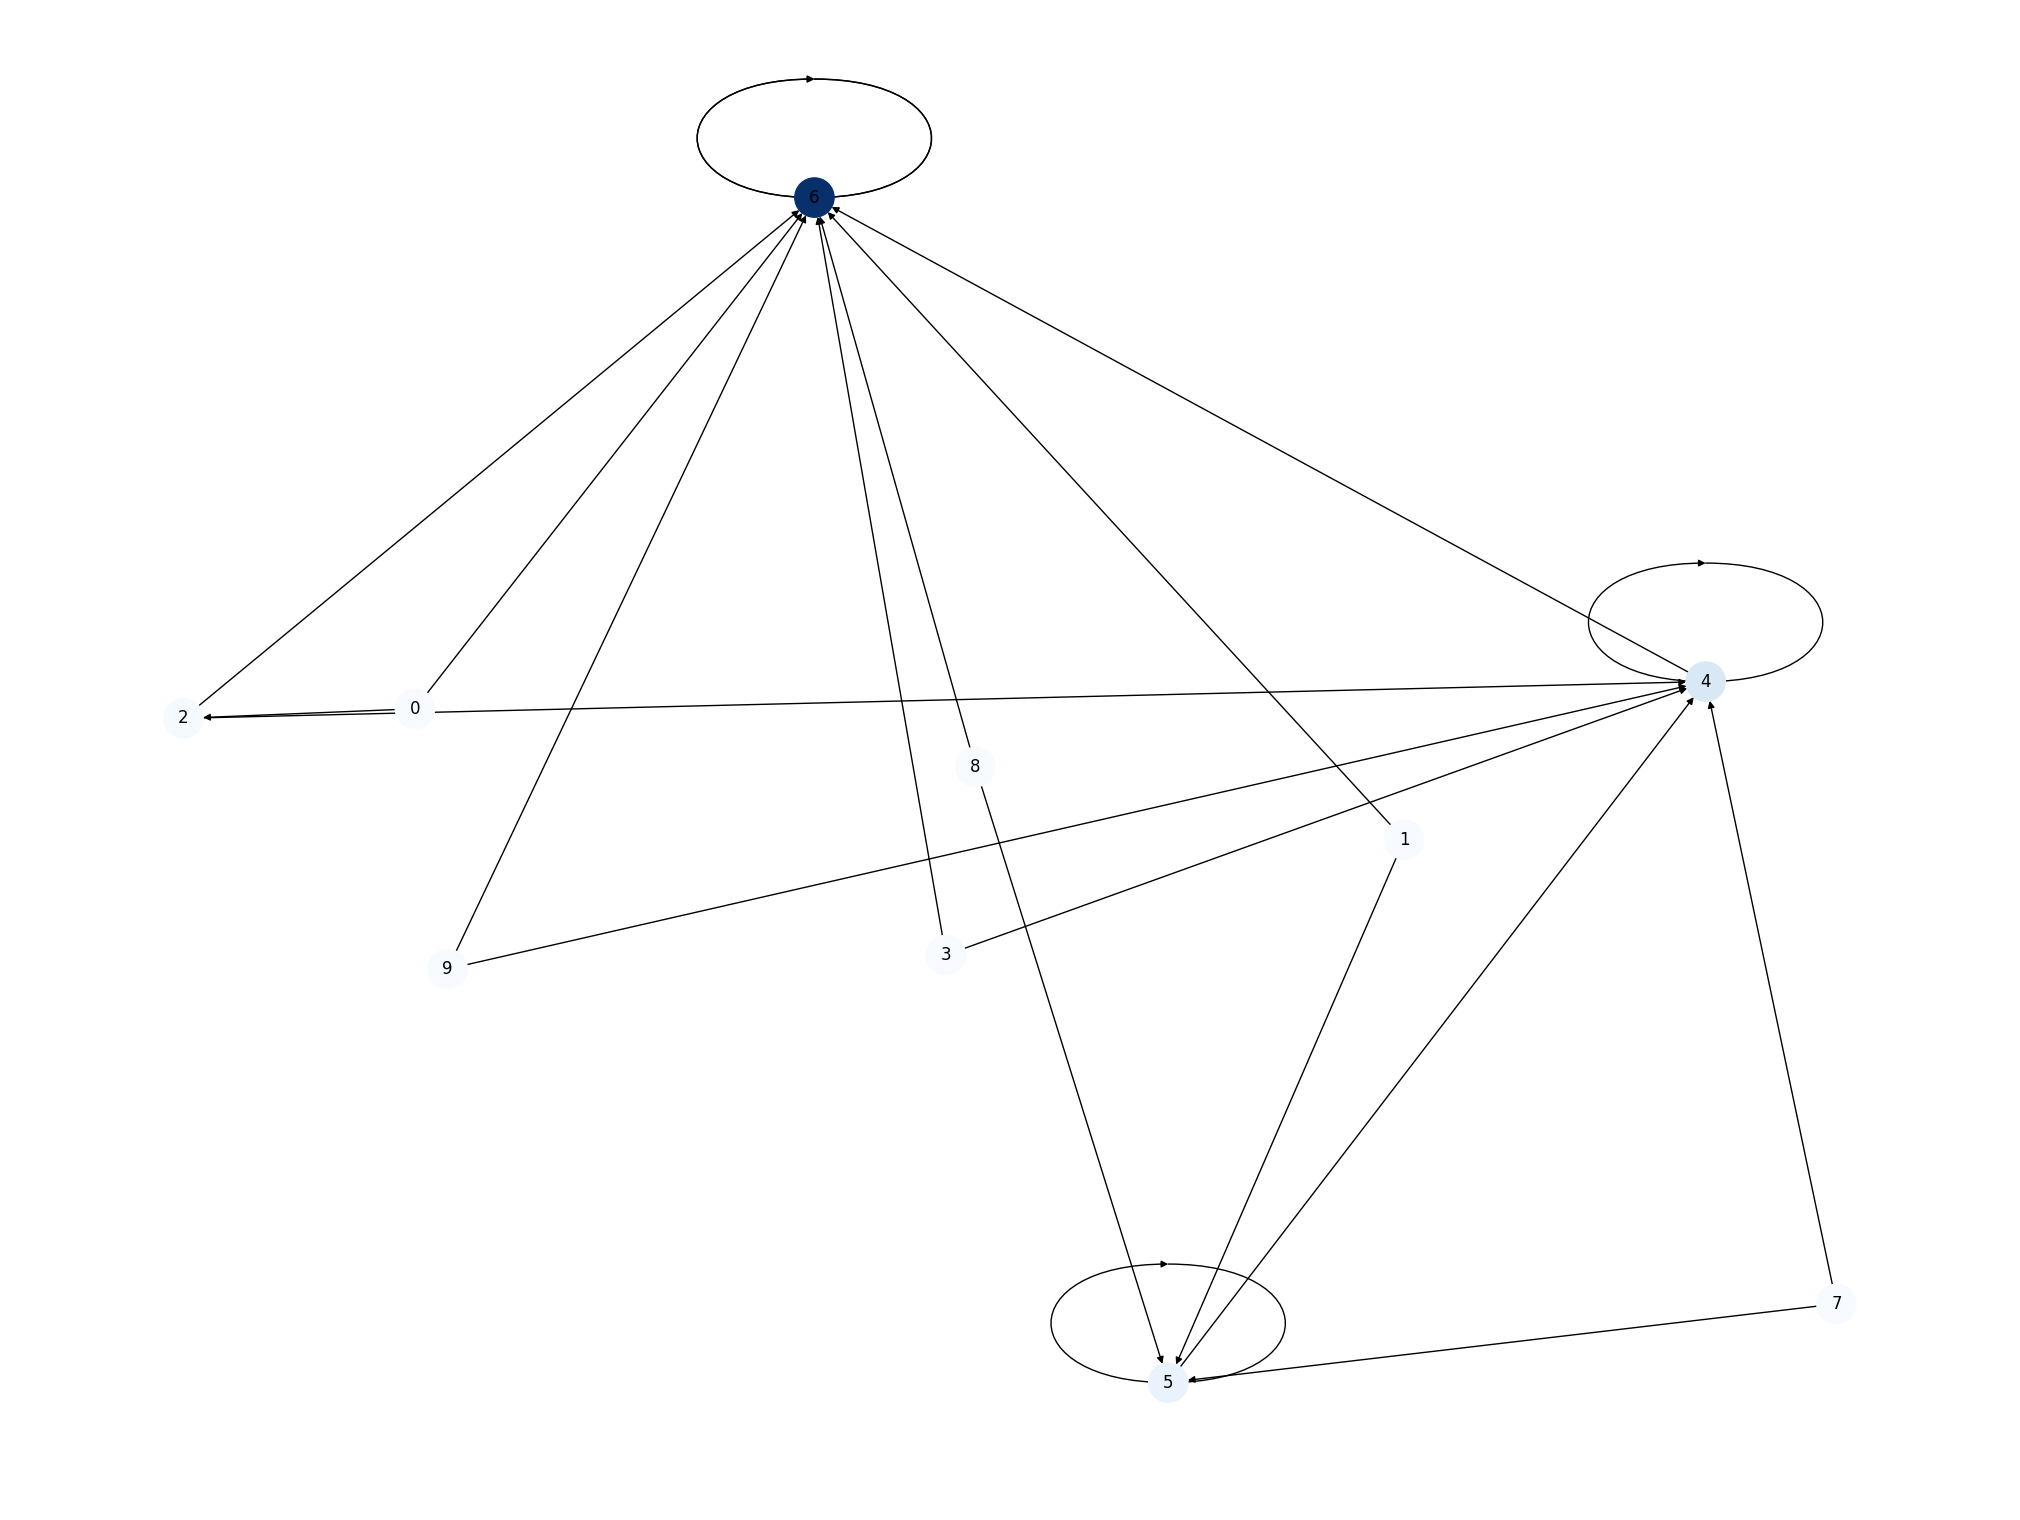

In [22]:
#TODO
rangs_pr = nx.pagerank(G)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

## Éléments propres et vecteur de Perron-Frobenius

En initialisant cet algorithme de produits itérés avec presque n'importe quel vecteur, le résultat convergera vers le vecteur propre de la matrice qui correspond à la plus grande valeur propre de `GM`. Ce vecteur, correspondant à la sortie de **PageRank**, est aussi appelé **vecteur de Perron Frobenius** (à gauche) de la "Google Matrix" `GM`.

(En algèbre linéaire numérique, la multiplication répétée est l'un des algorithmes utilisés pour calculer les valeurs propres : on l'appelle [méthode de la puissance itérée](https://fr.wikipedia.org/wiki/M%C3%A9thode_de_la_puissance_it%C3%A9r%C3%A9e).)

Au lieu d'utiliser une méthode itérative, nous pouvons également calculer directement les valeurs propres, ce que fait la fonction Numpy `eig`.

Calculer les valeurs propres et les vecteurs propres à gauche de la matrice de Google. 

_Attention_: la fonction `la.eig` calcule nativement les éléments propres à droite.

In [23]:
#TODO

Vérifier que $1$ est valeur propre simple, et qu'elle est de plus grand module dans le spectre de `GM`.

In [24]:
#TODO

In [25]:
#TODO

Le résultat contient des nombres complexes, mais les parties imaginaires sont toutes presque nulles, nous pouvons donc extraire uniquement la partie réelle. Pour cela, utiliser la fonction `z.real` qui calcule la partie réelle de `z`.

In [26]:
#TODO

Normaliser le résultat pour que les coefficients du vecteur somment à $1$.

In [27]:
#TODO

Comparer le résultat avec la sortie de `nx.pagerank`. 

In [28]:
#TODO


## Coder Pagerank !

Écrire un programme renvoyant une approximation de PageRank sur le graphe `G`, avec pour paramètre de téléportation `alpha`, et précision `eps` pour l'approximation du vecteur de Perron-Frobenius par méthode de la puissance.

In [29]:
def google_matrix(G, alpha=0.85):
    """
    returns the pagerank matrix associated with G
    """
    GM=GM.copy()
    return GM

def PageRankEigen(G,alpha=.85,eps=1e-5):
    """
    return, via the iterative method, the Perron-Frobenius eigenvalue
    """
    x = np.full(1, 1)


    return y

In [30]:
#comparaison

# Applications #



## Personnages importants dans "Les Misérables" ##

Calculer l'importance donnée par PageRank dans le graphe des co-occurences des personnages des Misérables. On comparera avec la mesure de centralité associée au degré.

In [31]:
miserables=nx.generators.les_miserables_graph()